<div style="display: flex; justify-content: space-between; align-items: center;">
  <img src="BUE.png" style="width: 200px;">
  <img src="Zewail-City.png" style="width: 200px;">
</div>

---

# __Solar Wind Heliospheric 3D Analysis__

In [1]:
# Required libraries
import numpy as np
import pandas as pd
import scipy as sc
from scipy.constants import m_p, k as kB, e, pi
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation, PillowWriter
import seaborn as sns
from IPython.display import display, Math

In [2]:
# === Constants ===
m_p = 1.6726e-27  # kg (proton mass)
kB = 1.3807e-23   # J/K
m_alpha = 4 * m_p  # kg (2 protons + 2 neutrons)
mu0 = 4 * np.pi * 1e-7         # Vacuum permeability [H/m]
nT_to_T = 1e-9                 # nT → T
cm3_to_m3 = 1e6                # cm⁻³ → m⁻³
gamma = 5/3

# __Data imported from helios 2  (1974-1980)__


## **Data**
Now you have solar wind core protons data and magnetic field data measured by helios 2 from 1974 to 1980.
The data are defined by the column names as the following,

| Quantity | Symbol | Units | Key |
|---------|--------|-------|-----|
| Radial Distance | — | AU | `Helios2['r_sun']` |
| x-component magnetic field | $ B_x $ | nT | `Helios2['Bx']` |
| y-component magnetic field | $ B_y $ | nT | `Helios2['By']` |
| z-component magnetic field | $ B_z $ | nT | `Helios2['Bz']` |
| Proton core density | $ n_p $ | cm⁻³ | `Helios2['n_p']` |
| Parallel proton temperature | $ T_{\parallel p} $ | K | `Helios2['Tp_par']` |
| Perpendicular proton temperature | $ T_{\perp p} $ | K | `Helios2['Tp_perp']` |
| x-component proton velocity | $ v_{px} $ | km/s | `Helios2['vp_x']` |
| y-component proton velocity | $ v_{py} $ | km/s | `Helios2['vp_y']` |
| z-component proton velocity | $ v_{pz} $ | km/s | `Helios2['vp_z']` |
| Parallel proton thermal velocity | $ v_{th p \parallel} $ | km/s | `Helios2['vth_p_par']` |
| Perpendicular proton thermal velocity | $ v_{th p \perp} $ | km/s | `Helios2['vth_p_perp']` |
| Radial magnetic field | $ B_r $ | nT | `Helios2['B_r']` |
| Tangential magnetic field | $ B_t $ | nT | `Helios2['B_tan']` |
| Magnetic field magnitude | $ B $ | nT | `Helios2['B']` |
| Parallel specific entropy | $ S_{\parallel} $ | eV cm⁻² | `Helios2['S_par']` |
| Perpendicular specific entropy | $ S_{\perp} $ | eV cm⁻² | `Helios2['S_perp']` |
| Radial velocity | $ V_r $ | km/s | `Helios2['V_r']` |
| Radial density flux | $ f_r $ | #/s | `Helios2['flux_r']` |
| Total proton temperature | $ T_p $ | K | `Helios2['Tp']` |


# **Data Visualization:** SW: Heating, Escaping, and Accelerating.

In [3]:
# Step 4: Load the CSV file 

Helios2 = pd.read_csv("Helios2_solar_wind_data.csv")
Helios2.columns[0:]

Index(['Time', 'B instrument', 'Bx', 'By', 'Bz', 'sigma B', 'Ion instrument',
       'Status', 'Tp_par', 'Tp_perp', 'carrot', 'r_sun', 'clat', 'clong',
       'earth_he_angle', 'n_p', 'vp_x', 'vp_y', 'vp_z', 'vth_p_par',
       'vth_p_perp'],
      dtype='object')

# **Core Quantities:**

### 1. Radial Magnetic Field Component
$$
B_r = B_x
$$
**Meaning**: The component of the magnetic field aligned with the Sun–spacecraft radial direction. Essential in solar wind and Parker spiral analysis.

### 2. Tangential Magnetic Field Magnitude
$$
B_{\text{tan}} = \sqrt{B_y^2 + B_z^2}
$$
**Meaning**: The magnetic field component perpendicular to the radial direction. Used to analyze the helical structure of the interplanetary magnetic field.

### 3. Total Magnetic Field Magnitude
$$
B = \sqrt{B_x^2 + B_y^2 + B_z^2}
$$
**Meaning**: The overall strength of the magnetic field vector at the spacecraft position.

### 4. Parallel Specific Entropy (per particle)
$$
S_{\parallel} = \frac{T_{p,\parallel}}{n_p^{2/3}}
\quad \text{[units: K·cm}^{2}\text{]}
$$
**Meaning**: A proxy for the entropy of a proton population under adiabatic evolution along the field direction. Used to track compressive and expansive heating.

### 5. Perpendicular Specific Entropy (magnetic constraint)
$$
S_{\perp} = \frac{T_{p,\perp}}{n_p B}
\quad \text{[units: K·cm}^{3} \cdot \text{nT}^{-1}]
$$
**Meaning**: Reflects the conservation of the magnetic moment. Sensitive to magnetic field variations and perpendicular heating.

### 6. Radial Velocity Magnitude
$$
V_r = \sqrt{v_{p,x}^2 + v_{p,y}^2 + v_{p,z}^2}
\quad \text{[units: km/s]}
$$
**Meaning**: Bulk speed of the solar wind plasma as measured in 3D space.

### 7. Radial Particle Flux
$$
\Phi_r = n_p \, V_r \, r_{\odot}^2
\quad \text{[units: s}^{-1}]
$$
**Meaning**: Number of particles crossing a spherical surface at radius $ r_{\odot} $; useful for solar wind mass-loss studies.

### 8. Total Proton Temperature
$$
T_p = \frac{T_{p,\parallel} + 2 T_{p,\perp}}{3}
\quad \text{[units: K]}
$$
**Meaning**: The scalar temperature assuming gyrotropy; averages motion in all directions.


In [4]:
# === Core Quantities from Helios2 ===

# Radial magnetic field component
Helios2['B_r'] = Helios2['Bx']  

# Tangential magnetic field magnitude
Helios2['B_tan'] = np.sqrt(Helios2['By']**2 + Helios2['Bz']**2)

# Total magnetic field magnitude
Helios2['B'] = np.sqrt(Helios2['Bx']**2 + Helios2['By']**2 + Helios2['Bz']**2)

# Parallel specific entropy
Helios2['S_par'] = Helios2['Tp_par'] / Helios2['n_p']**(2/3)

# Perpendicular specific entropy
Helios2['S_perp'] = Helios2['Tp_perp'] / (Helios2['n_p'] * Helios2['B'])

# Radial velocity magnitude
Helios2['V_r'] = np.sqrt(Helios2['vp_x']**2 + Helios2['vp_y']**2 + Helios2['vp_z']**2)

# Radial density flux (assuming spherical symmetry)
Helios2['flux_r'] = Helios2['n_p'] * Helios2['V_r'] * Helios2['r_sun']**2

# Total proton temperature
Helios2['Tp'] = (Helios2['Tp_par'] + 2 * Helios2['Tp_perp']) / 3


# **Additional Plasma Quantities**

### 9. Parallel Plasma Beta
$$
\beta_\parallel = \frac{\mu_0 n_p k_B T_{p,\parallel}}{B^2}
$$
**Meaning**: Ratio of thermal pressure (along field) to magnetic pressure. Indicates the influence of thermal dynamics vs. magnetic confinement.

### 10. Perpendicular Plasma Beta
$$
\beta_\perp = \frac{\mu_0 n_p k_B T_{p,\perp}}{B^2}
$$
**Meaning**: Same as above, but for perpendicular thermal motion. Relevant for understanding anisotropy-driven instabilities.

### 11. Total Plasma Beta
$$
\beta = \frac{2 \mu_0 n_p k_B T_p}{B^2}
$$
**Meaning**: Total pressure ratio; $ \beta > 1 $ implies thermal dynamics dominate, $ \beta < 1 $ implies magnetic dominance.

### 12. Alfvén Speed
$$
V_A = \frac{B}{\sqrt{\mu_0 n_p m_p}}
\quad \text{[units: m/s]}
$$
**Meaning**: Speed at which Alfvén waves (magnetic disturbances) propagate in the plasma.

### 13. Alfvén Mach Number
$$
M_A = \frac{V_r}{V_A}
$$
**Meaning**: Compares solar wind speed to the Alfvén speed. $ M_A > 1 $ indicates super-Alfvénic flow (common in solar wind).

### 14. Thermal Pressure
$$
P_{\text{th}} = n_p \, k_B \, T_p
\quad \text{[units: Pa]}
$$
**Meaning**: Scalar pressure due to proton thermal motion. Affects dynamics and wave propagation.

### 15. Magnetic Pressure
$$
P_B = \frac{B^2}{2 \mu_0}
\quad \text{[units: Pa]}
$$
**Meaning**: Effective pressure exerted by the magnetic field. Competes with thermal pressure in determining plasma behavior.

### 16. Proton Magnetic Moment Proxy
$$
\mu_p = \frac{T_{p,\perp}}{B}
\quad \text{[units: K·nT}^{-1}]
$$
**Meaning**: Tracks the conservation of the magnetic moment in collisionless plasmas; central to adiabatic theory and perpendicular heating analysis.


In [5]:
# === Additional Plasma Quantities ===

# Convert to SI units for plasma physics calculations
n_p_m3 = Helios2['n_p'] * cm3_to_m3    # number density [m⁻³]
B_T    = Helios2['B'] * nT_to_T        # magnetic field [T]
Tp_par = Helios2['Tp_par']
Tp_perp = Helios2['Tp_perp']
Tp = Helios2['Tp']

# Plasma beta (thermal to magnetic pressure ratios)
Helios2['beta_par']  = (mu0 * n_p_m3 * kB * Tp_par) / B_T**2
Helios2['beta_perp'] = (mu0 * n_p_m3 * kB * Tp_perp) / B_T**2
Helios2['beta']      = (2 * mu0 * n_p_m3 * kB * Tp) / B_T**2

# Alfvén speed
Helios2['V_A'] = B_T / np.sqrt(mu0 * n_p_m3 * m_p)  # [m/s]

# Alfvén Mach number
Helios2['M_A'] = (Helios2['V_r'] * 1e3) / Helios2['V_A']  # Convert km/s → m/s

# Thermal pressure
Helios2['P_th'] = n_p_m3 * kB * Tp  # [Pa]

# Magnetic pressure
Helios2['P_B'] = B_T**2 / (2 * mu0)  # [Pa]

# Proton magnetic moment proxy
Helios2['mu_p'] = Tp_perp / Helios2['B']  # [K/nT]


# **More Macroscopic Quantities**

### 17. Dynamic Pressure
$$
P_{\text{dyn}} = \rho u^2 = m_p n_p V_r^2
\quad \text{[units: Pa]}
$$
**Meaning**: Momentum flux of the solar wind. Relevant in solar wind–magnetosphere interactions.

### 18. Thermal Mach Number
$$
M = \frac{V_r}{v_{\text{th}}}
$$
**Meaning**: Measures whether the flow is faster than the random thermal motion; important for characterizing flow regimes.

### 19. Sound Speed
$$
c_s = \sqrt{ \frac{\gamma k_B T_p}{m_p} }
\quad \text{[units: m/s]}
$$
**Meaning**: Speed of compressional waves; important for wave propagation and compressibility analysis.

### 20. Enthalpy per Unit Mass
$$
h = \frac{5}{2} \cdot \frac{k_B T_p}{m_p}
\quad \text{[units: J/kg]}
$$
**Meaning**: Measures internal energy content per unit mass; useful in thermodynamic studies and solar wind heating models.


In [8]:
# === Additional Macroscopic Quantities ===

# Dynamic pressure
Helios2['P_dyn'] = m_p * n_p_m3 * (Helios2['V_r'] * 1e3)**2  # [Pa]

# Thermal speed (1D approximation)
Helios2['v_th'] = np.sqrt(kB * Tp / m_p)  # [m/s]

# Thermal Mach number
Helios2['M_th'] = (Helios2['V_r'] * 1e3) / Helios2['v_th']

# Sound speed (assuming gamma = 5/3 for monoatomic ideal gas)
Helios2['c_s'] = np.sqrt(gamma * kB * Tp / m_p)  # [m/s]

# Enthalpy per unit mass
Helios2['h'] = (5/2) * kB * Tp / m_p  # [J/kg]

# Preview updated DataFrame
Helios2.head()


Time  B instrument        Bx        By         Bz  sigma B  \
0  1976-04-05 00:01:21             1  23.83600  0.705618   0.685393  3.72097   
1  1976-04-05 00:02:42             1  22.19540 -7.965520   1.013790  3.53517   
2  1976-04-05 00:04:03             1  13.72200 -8.123080  16.582400  3.56085   
3  1976-04-05 00:05:24             1   6.03218  1.362070  21.446000  6.70185   
4  1976-04-05 00:06:45             1  12.35820  4.762640  18.670300  7.36371   

   Ion instrument  Status    Tp_par   Tp_perp  ...            V_A       M_A  \
0               1       1  107061.0  343451.0  ...  124228.226207  4.316176   
1               1       1  117018.0  369263.0  ...  116730.432828  4.732820   
2               1       1  103427.0  383388.0  ...  115139.080632  5.162909   
3               1       1  124121.0  306238.0  ...  118891.614061  5.221751   
4               1       1  187078.0  252321.0  ...  127063.835248  4.336600   

           P_th           P_B          mu_p         P_dyn       M_th  \
0  6.411234e-11  2.264467e-10  14396.664565  8.437120e-09  11.471661   
1  7.659380e-11  2.216682e-10  15644.587763  9.930554e-09  11.386492   
2  7.607029e-11  2.105834e-10  16665.047773  1.122647e-08  12.148257   
3  5.684393e-11  1.982169e-10  13720.465177  1.080943e-08  13.789846   
4  4.915683e-11  2.084882e-10  11022.820816  7.841700e-09  12.630287   

            c_s             h          v_th  
0  60341.693655  5.461680e+09  46740.474922  
1  62638.094634  5.885296e+09  48519.259471  
2  63172.440020  5.986136e+09  48933.161628  
3  58120.900777  5.067059e+09  45020.256155  
4  56322.578637  4.758349e+09  43627.281815  

[5 rows x 42 columns]

In [9]:
Helios2.columns

Index(['Time', 'B instrument', 'Bx', 'By', 'Bz', 'sigma B', 'Ion instrument',
       'Status', 'Tp_par', 'Tp_perp', 'carrot', 'r_sun', 'clat', 'clong',
       'earth_he_angle', 'n_p', 'vp_x', 'vp_y', 'vp_z', 'vth_p_par',
       'vth_p_perp', 'B_r', 'B_tan', 'B', 'S_par', 'S_perp', 'V_r', 'flux_r',
       'Tp', 'beta_par', 'beta_perp', 'beta', 'V_A', 'M_A', 'P_th', 'P_B',
       'mu_p', 'P_dyn', 'M_th', 'c_s', 'h', 'v_th'],
      dtype='object')

In [10]:
# === Clean Data ===
df_B = Helios2[['Bx', 'By', 'Bz', 'B_r', 'B_tan']].dropna()

Bx, By, Bz = df_B['Bx'].values, df_B['By'].values, df_B['Bz'].values
B_r, B_tan = df_B['B_r'].values, df_B['B_tan'].values


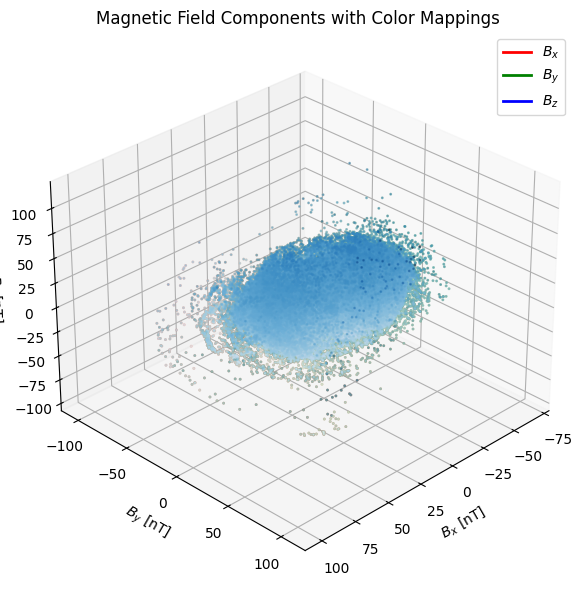

In [11]:
# === Figure 1: 3D Scatter Plot of Bx, By, Bz (Colored Separately) ===
fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111, projection='3d')

# Normalize for colormaps
norm_Bx = plt.Normalize(Bx.min(), Bx.max())
norm_By = plt.Normalize(By.min(), By.max())
norm_Bz = plt.Normalize(Bz.min(), Bz.max())

# Scatter for Bx with Reds
sc1 = ax1.scatter(Bx, By, Bz, c=Bx, cmap='Reds', norm=norm_Bx, s=1, alpha=0.4, label='$B_x$')

# Scatter for By with Greens
sc2 = ax1.scatter(Bx, By, Bz, c=By, cmap='Greens', norm=norm_By, s=1, alpha=0.4, label='$B_y$')

# Scatter for Bz with Blues
sc3 = ax1.scatter(Bx, By, Bz, c=Bz, cmap='Blues', norm=norm_Bz, s=1, alpha=0.4, label='$B_z$')

# Labels and rotation
ax1.set_title('Magnetic Field Components with Color Mappings')
ax1.set_xlabel('$B_x$ [nT]')
ax1.set_ylabel('$B_y$ [nT]')
ax1.set_zlabel('$B_z$ [nT]')
ax1.view_init(elev=30, azim=45)
ax1.grid(True)

# Optional: add a legend or colorbars if needed (colorbars may be redundant here since all points overlap)
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='$B_x$'),
    Line2D([0], [0], color='green', lw=2, label='$B_y$'),
    Line2D([0], [0], color='blue', lw=2, label='$B_z$')
]
ax1.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

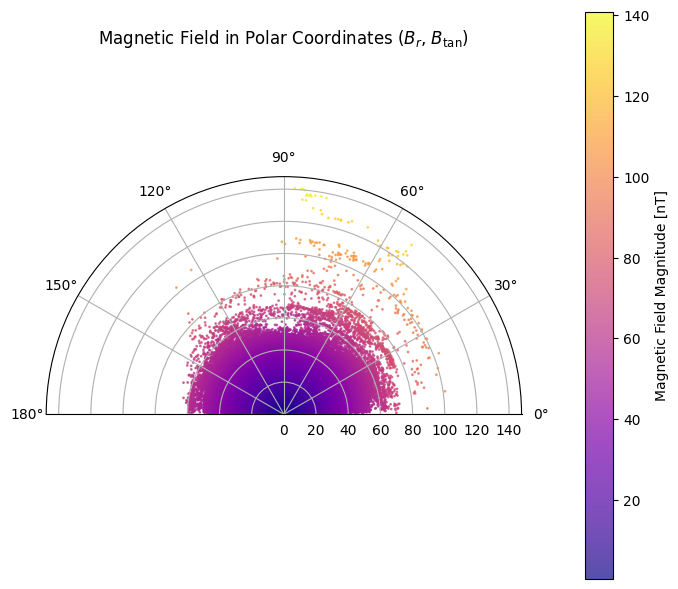

In [12]:
# === Figure 2: Polar Plot of B_r and B_tan (Half Circle) ===
fig2 = plt.figure(figsize=(7, 6))
ax2 = fig2.add_subplot(111, projection='polar')

# Compute angle and magnitude
theta = np.arctan2(B_tan, B_r)
B_mag = np.sqrt(B_r**2 + B_tan**2)

# Mask to show only upper half-circle (0 to π)
half_mask = (theta >= 0) & (theta <= np.pi)

# Plot on polar axis
sc = ax2.scatter(theta[half_mask], B_mag[half_mask],
                 c=B_mag[half_mask], cmap='plasma', s=1, alpha=0.7)

ax2.set_title('Magnetic Field in Polar Coordinates ($B_r$, $B_{\\rm tan}$)', va='bottom')
ax2.set_thetamin(0)
ax2.set_thetamax(180)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax2, pad=0.1)
cbar.set_label('Magnetic Field Magnitude [nT]')

plt.tight_layout()
plt.show()

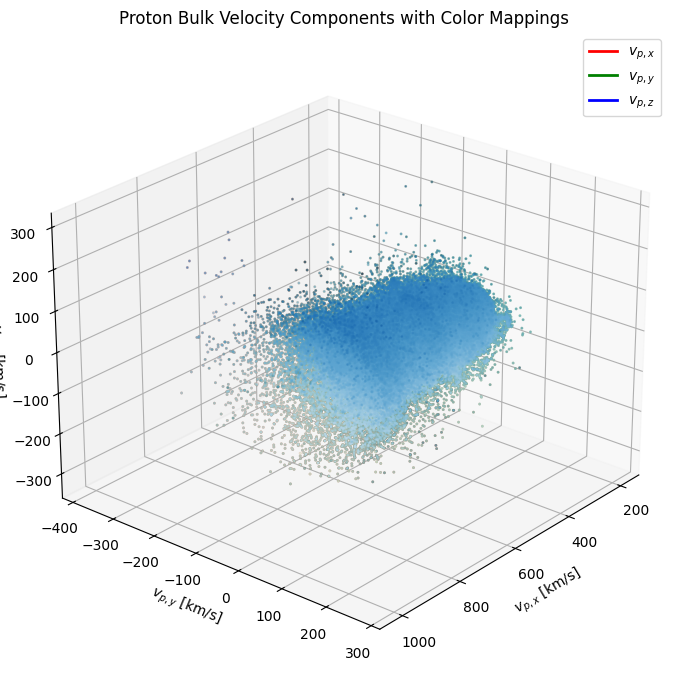

In [13]:
# === Clean Velocity Data ===
df_v = Helios2[['vp_x', 'vp_y', 'vp_z']].dropna()
vx, vy, vz = df_v['vp_x'].values, df_v['vp_y'].values, df_v['vp_z'].values

# === Create 3D Figure ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Normalize each component for consistent color mapping
norm_vx = plt.Normalize(vx.min(), vx.max())
norm_vy = plt.Normalize(vy.min(), vy.max())
norm_vz = plt.Normalize(vz.min(), vz.max())

# Scatter plots for each component
ax.scatter(vx, vy, vz, c=vx, cmap='Reds', norm=norm_vx, s=1, alpha=0.4, label='$v_{p,x}$')
ax.scatter(vx, vy, vz, c=vy, cmap='Greens', norm=norm_vy, s=1, alpha=0.4, label='$v_{p,y}$')
ax.scatter(vx, vy, vz, c=vz, cmap='Blues', norm=norm_vz, s=1, alpha=0.4, label='$v_{p,z}$')

# Labels and title
ax.set_title('Proton Bulk Velocity Components with Color Mappings')
ax.set_xlabel('$v_{p,x}$ [km/s]')
ax.set_ylabel('$v_{p,y}$ [km/s]')
ax.set_zlabel('$v_{p,z}$ [km/s]')

# Rotate view
ax.view_init(elev=25, azim=40)
ax.grid(True)

# Legend using color lines
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='$v_{p,x}$'),
    Line2D([0], [0], color='green', lw=2, label='$v_{p,y}$'),
    Line2D([0], [0], color='blue', lw=2, label='$v_{p,z}$')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


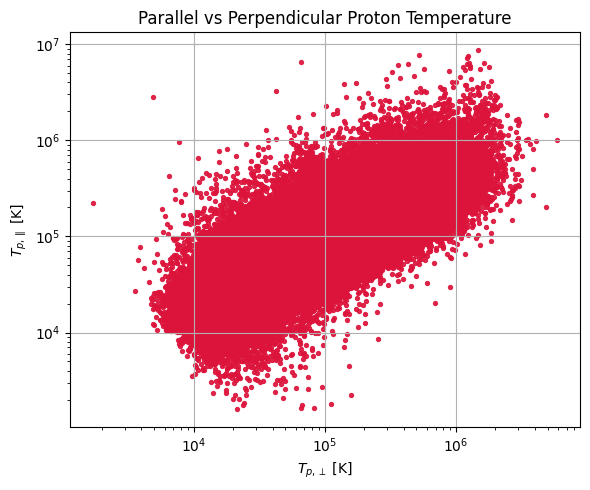

In [14]:
df_T = Helios2[['Tp_par', 'Tp_perp']].dropna()

plt.figure(figsize=(6, 5))
plt.scatter(df_T['Tp_perp'],df_T['Tp_par'], s=8, alpha=0.9, color='crimson')

plt.ylabel('$T_{p,\\parallel}$ [K]')
plt.xlabel('$T_{p,\\perp}$ [K]')
plt.title('Parallel vs Perpendicular Proton Temperature')
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

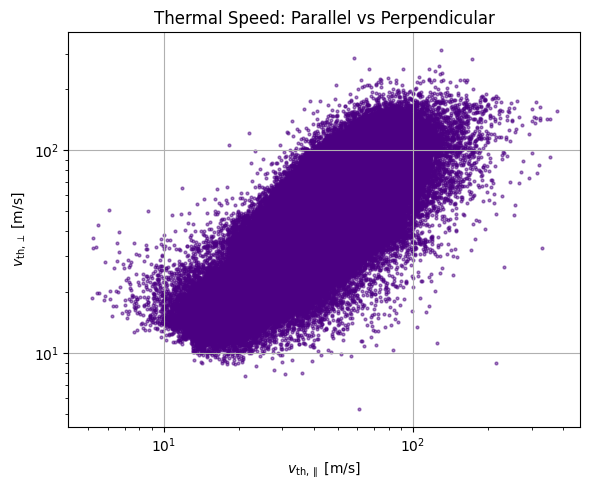

In [15]:
df_th = Helios2[['vth_p_par', 'vth_p_perp']].dropna()

plt.figure(figsize=(6, 5))
plt.scatter(df_th['vth_p_par'], df_th['vth_p_perp'], s=4, alpha=0.5, color='indigo')

plt.xlabel('$v_{{\\rm th},\\parallel}$ [m/s]')
plt.ylabel('$v_{{\\rm th},\\perp}$ [m/s]')
plt.title('Thermal Speed: Parallel vs Perpendicular')
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()


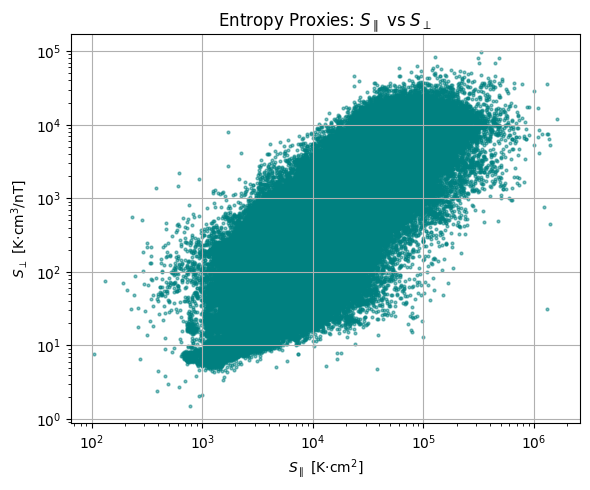

In [16]:
df_S = Helios2[['S_par', 'S_perp']].dropna()

plt.figure(figsize=(6, 5))
plt.scatter(df_S['S_par'], df_S['S_perp'], s=4, alpha=0.5, color='teal')

plt.xlabel('$S_\\parallel$ [K·cm$^2$]')
plt.ylabel('$S_\\perp$ [K·cm$^3$/nT]')
plt.title('Entropy Proxies: $S_\\parallel$ vs $S_\\perp$')
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

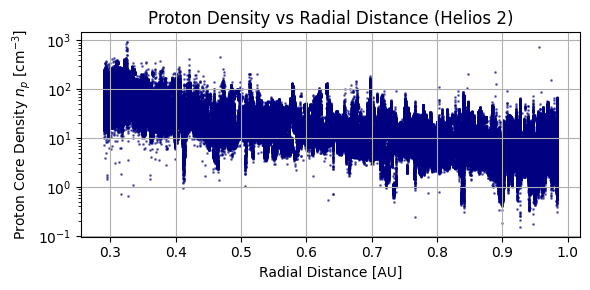

In [17]:
# Plot the Proton core density vs Radial distance

plt.figure(figsize=(6,3))
plt.scatter(Helios2['r_sun'], Helios2['n_p'], s=1, alpha=0.5, color='navy')

# Axis labels
plt.xlabel('Radial Distance [AU]')
plt.ylabel('Proton Core Density $n_p$ [cm$^{-3}$]')
plt.title('Proton Density vs Radial Distance (Helios 2)')
plt.grid(True)

plt.yscale('log')

plt.tight_layout()
plt.show()

In [18]:
# === Define grouped quantity-label pairs ===

# --- Core Quantities ---
core_quantities = [
    ('Bx', r'$B_x$ [nT]'),
    ('By', r'$B_y$ [nT]'),
    ('Bz', r'$B_z$ [nT]'),
    ('B_r', r'Radial B $B_r$ [nT]'),
    ('B_tan', r'Tangential B $B_{\rm tan}$ [nT]'),
    ('B', r'$|B|$ [nT]'),
    ('n_p', r'Density $n_p$ [cm$^{-3}$]'),
    ('Tp_par', r'$T_{p,\parallel}$ [K]'),
    ('Tp_perp', r'$T_{p,\perp}$ [K]'),
    ('Tp', r'Total Temp $T_p$ [K]'),
    ('vp_x', r'$v_{p,x}$ [km/s]'),
    ('vp_y', r'$v_{p,y}$ [km/s]'),
    ('vp_z', r'$v_{p,z}$ [km/s]'),
    ('V_r', r'$V_r$ [km/s]'),
    ('flux_r', r'Flux $n_p V_r r^2$ [#/s]'),
    ('S_par', r'$S_\parallel$ [K·cm$^2$]'),
    ('S_perp', r'$S_\perp$ [K·cm$^3$/nT]')
]

# --- Additional Plasma Quantities ---
plasma_quantities = [
    ('beta_par', r'$\beta_\parallel$'),
    ('beta_perp', r'$\beta_\perp$'),
    ('beta', r'Total $\beta$'),
    ('V_A', r'Alfvén Speed $V_A$ [m/s]'),
    ('M_A', r'Alfvén Mach $M_A$'),
    ('P_th', r'Thermal Pressure $P_{\rm th}$ [Pa]'),
    ('P_B', r'Magnetic Pressure $P_B$ [Pa]'),
    ('mu_p', r'Magnetic Moment Proxy $\mu_p$ [K/nT]')
]

# --- More Macroscopic Quantities ---
macro_quantities = [
    ('P_dyn', r'Dynamic Pressure $P_{\rm dyn}$ [Pa]'),
    ('v_th', r'Thermal Speed $v_{\rm th}$ [m/s]'),
    ('M_th', r'Thermal Mach $M_{\rm th}$'),
    ('c_s', r'Sound Speed $c_s$ [m/s]'),
    ('h', r'Specific Enthalpy $h$ [J/kg]')
]

In [19]:
def plot_quantities_grid(df, quantities, title, n_cols=3):
    import numpy as np
    import matplotlib.pyplot as plt

    n_rows = int(np.ceil(len(quantities) / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 4.2 * n_rows), sharex=True)
    axs = axs.flatten()

    for i, (key, label) in enumerate(quantities):
        ax = axs[i]

        # Skip if column missing or fully empty
        if key not in df.columns or df[key].dropna().empty:
            ax.axis('off')
            continue

        x = df['r_sun']
        y = df[key]
        mask = np.isfinite(x) & np.isfinite(y)
        x, y = x[mask], y[mask]

        if len(x) == 0 or len(y) == 0:
            ax.axis('off')
            continue

        ax.scatter(x, y, s=1, alpha=0.6, color='navy')
        ax.set_ylabel(label, fontsize=10)
        ax.grid(True)

        if (y > 0).all():
            ax.set_yscale('log')

    # Add x-labels to bottom row
    for ax in axs[-n_cols:]:
        if ax.has_data():
            ax.set_xlabel('Radial Distance [AU]', fontsize=11)

    # Turn off any remaining unused axes
    for j in range(len(quantities), len(axs)):
        axs[j].axis('off')

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

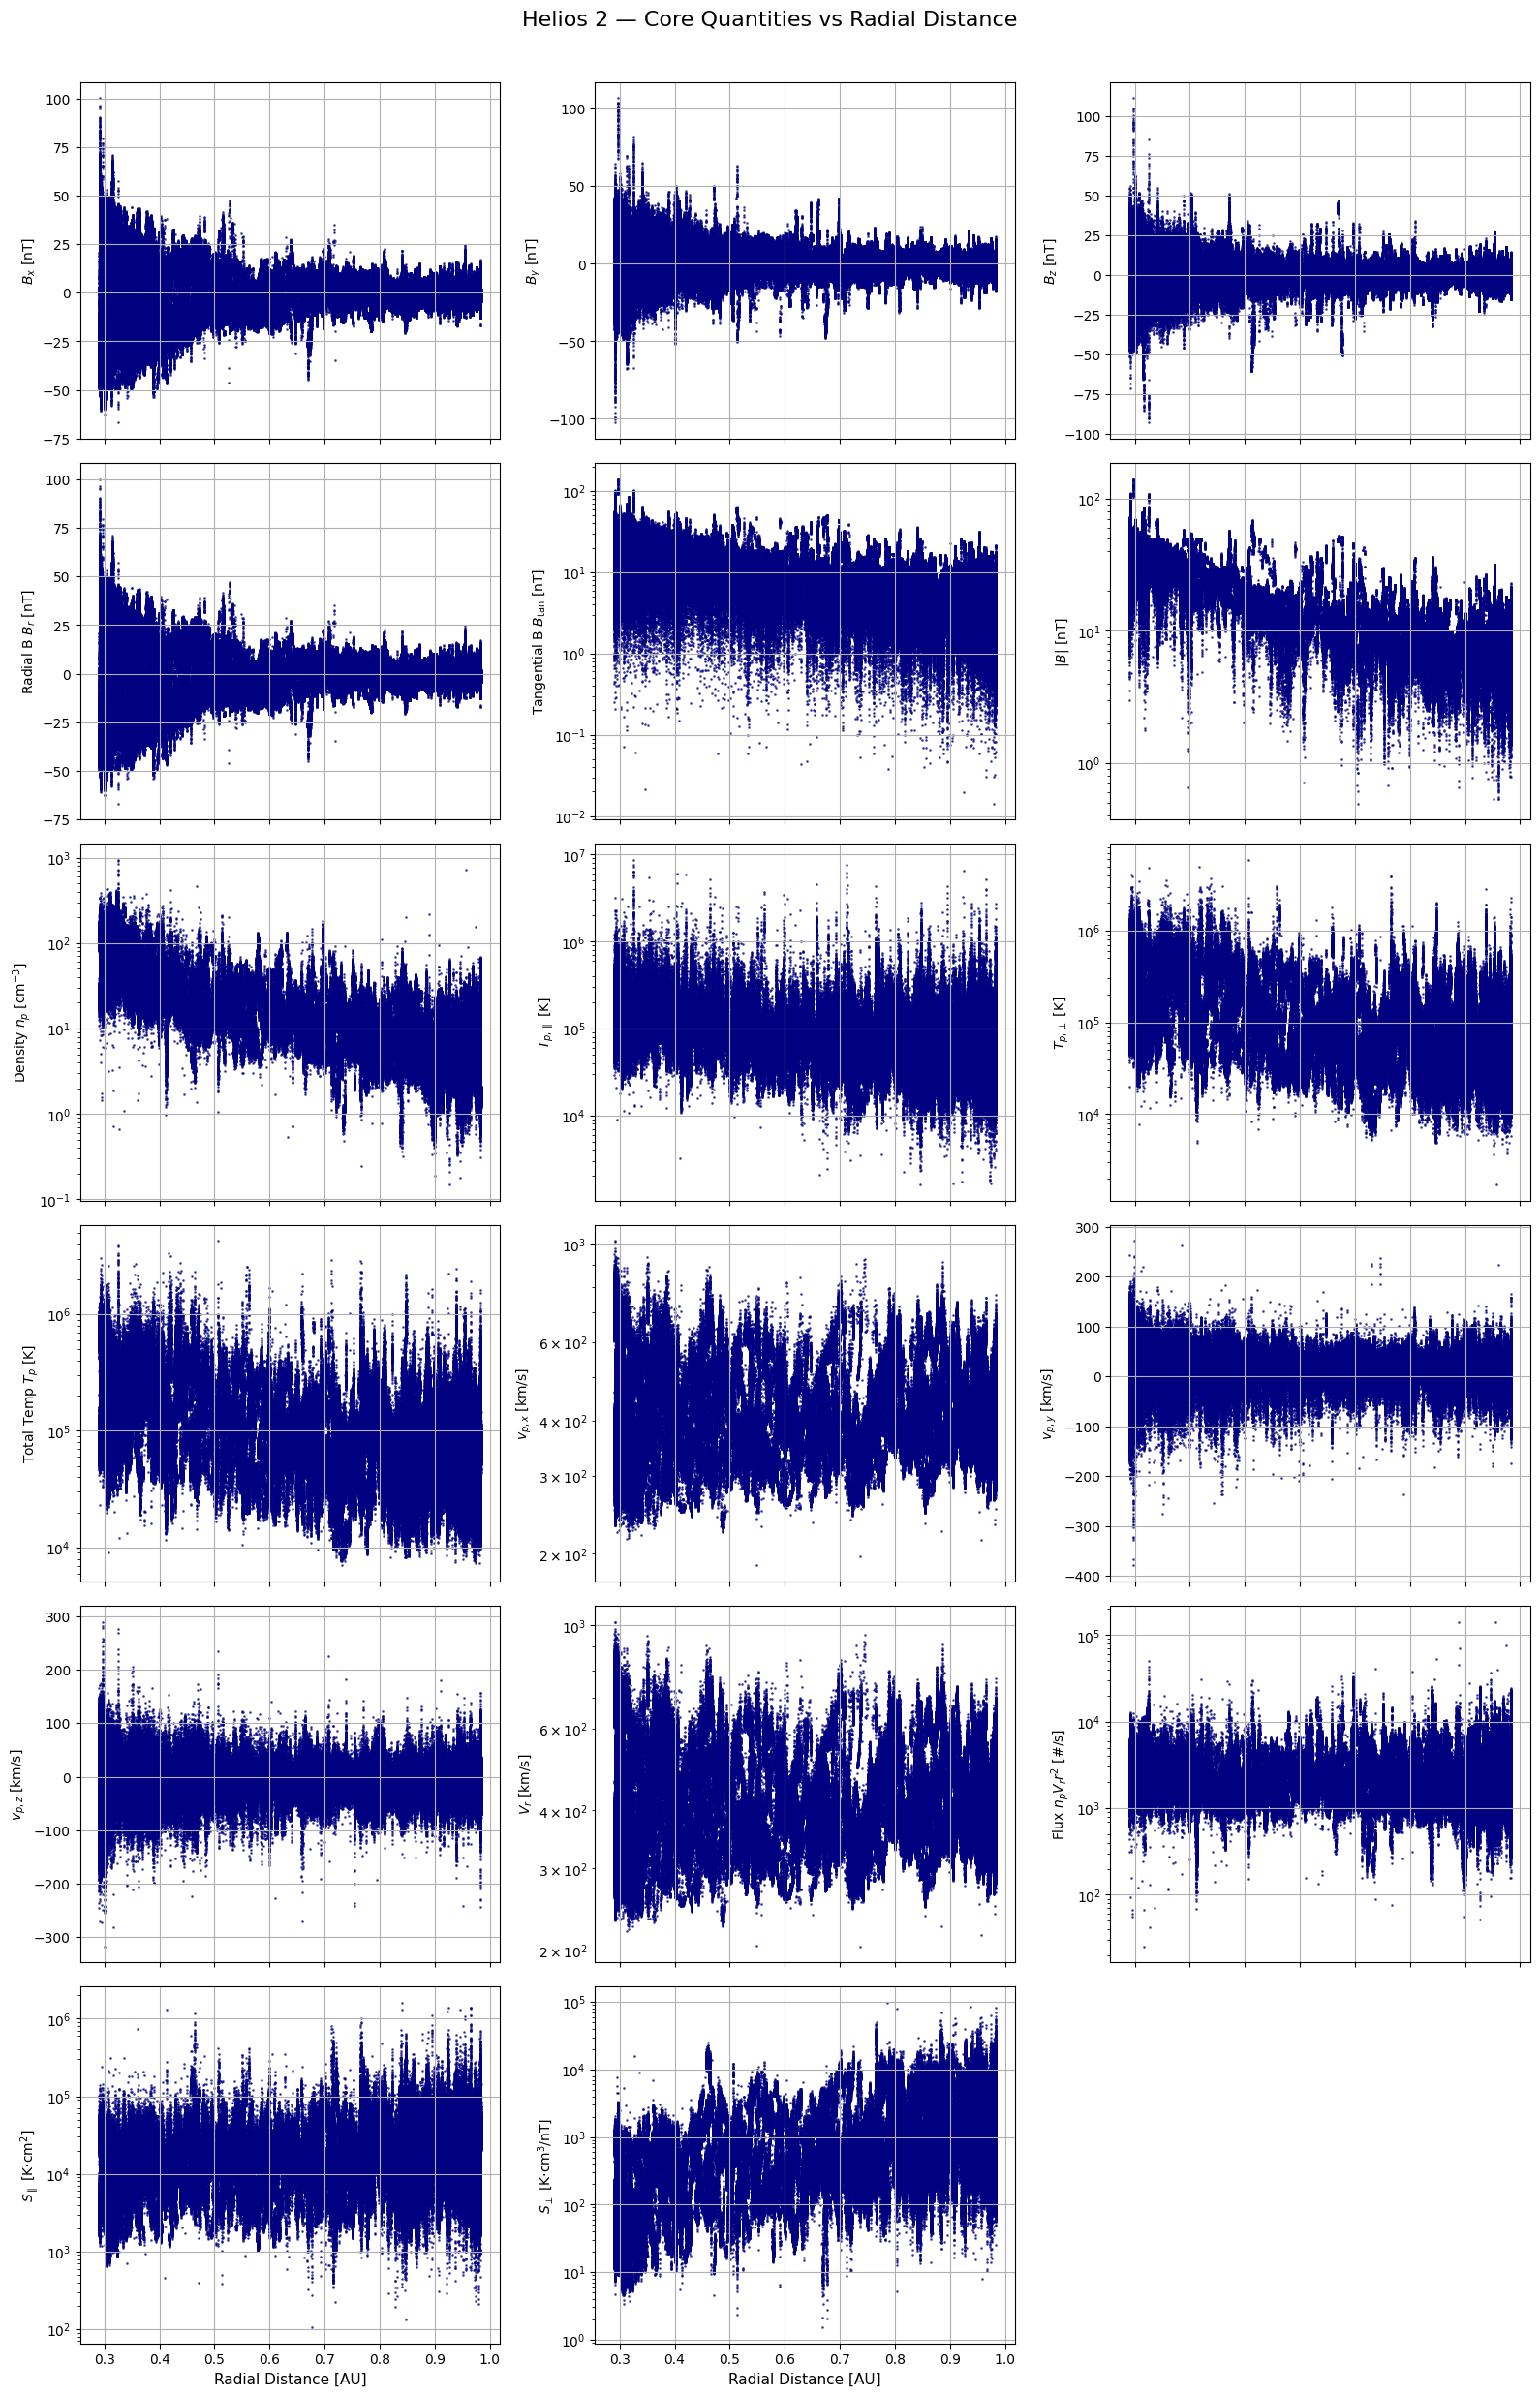

In [20]:
# === Plot each category ===
plot_quantities_grid(Helios2, core_quantities, "Helios 2 — Core Quantities vs Radial Distance")

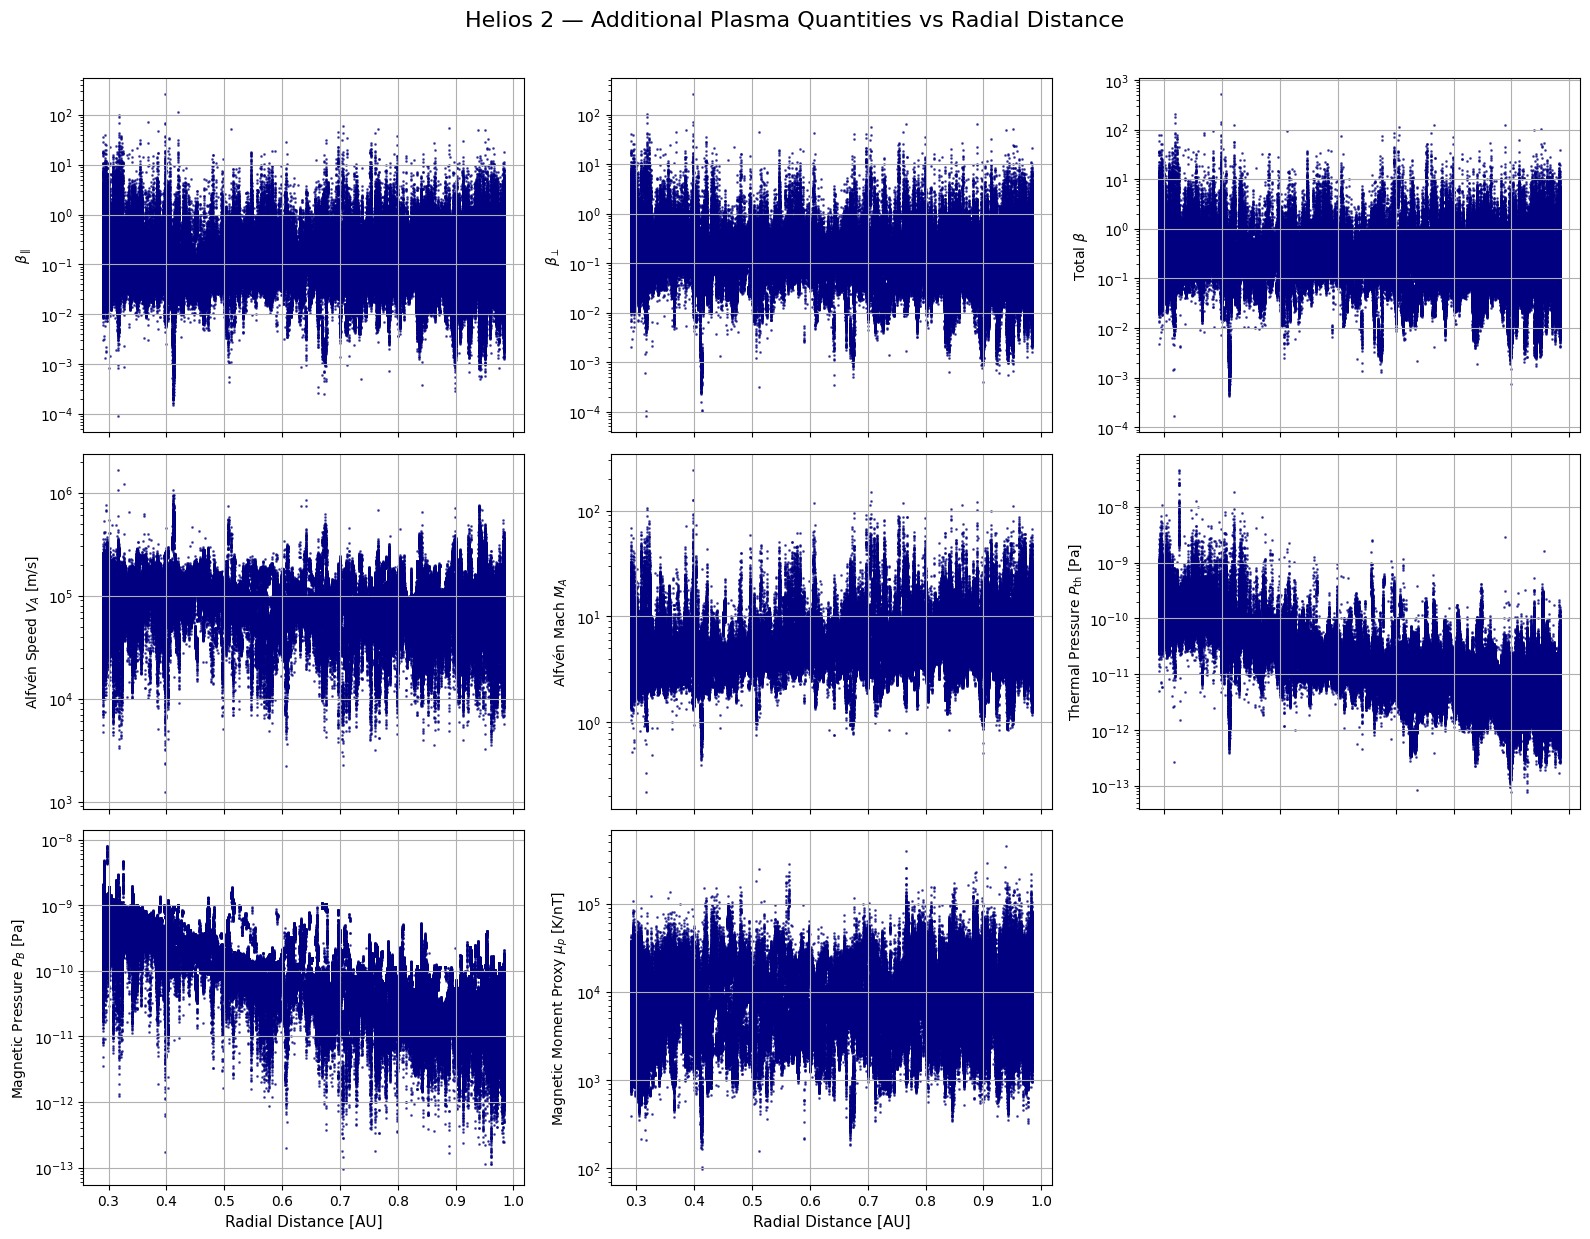

In [21]:
# === Plot Additional Plasma Quantities ===
plot_quantities_grid(Helios2, plasma_quantities, "Helios 2 — Additional Plasma Quantities vs Radial Distance")

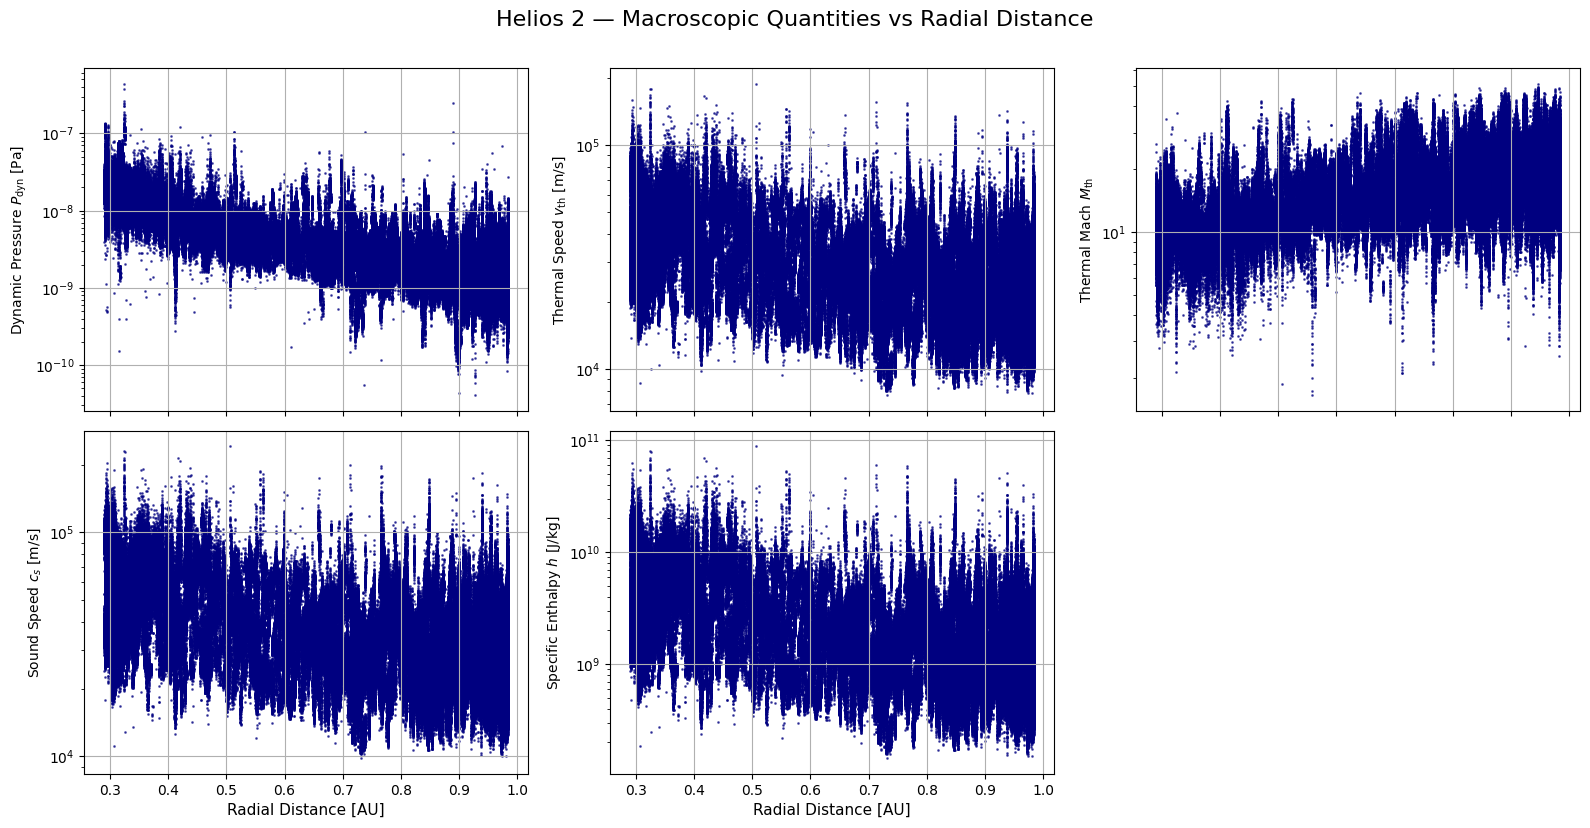

In [22]:
# === Plot Macroscopic Quantities ===
plot_quantities_grid(Helios2, macro_quantities, "Helios 2 — Macroscopic Quantities vs Radial Distance")

## Moving Average

A moving average is a simple yet powerful way to smooth out noisy data by averaging values over a sliding window.

Instead of plotting every raw data point—which may be scattered or dominated by short-term fluctuations—we compute the average of a small group of nearby points and slide that window across the dataset. This helps reveal long-term trends more clearly.

## How It Works (Step-by-Step)

Let’s say we have this sequence of solar wind speed measurements:

Raw data: [420, 430, 440, 500, 450, 460, 470, 490, 480]

Using a **moving average window of size 3**, we compute the average of every 3 consecutive points:

- (420 + 430 + 440)/3 = 430
- (430 + 440 + 500)/3 ≈ 456.7
- (440 + 500 + 450)/3 ≈ 463.3
- ...
- (470 + 490 + 480)/3 = 480

So the smoothed data becomes:

**[430, 456.7, 463.3, 470, 460, 473.3, 480]**

This version is less erratic and reveals the overall trend in the solar wind more clearly.


## Centered vs Non-Centered Moving Average

Consider this time series:
- Index: [0, 1, 2, 3, 4, 5]
- Values: [10, 12, 14, 20, 18, 16]

### With `center = False` (default behavior):

The average is assigned to the **right-most** point in the window:

- [10, 12, 14] → 12 → assigned to index **2**
- [12, 14, 20] → 15.3 → index **3**
- [14, 20, 18] → 17.3 → index **4**
- [20, 18, 16] → 18 → index **5**

➡ The result is **shifted rightward** (delayed).

---

### With `center = True`:

The average is assigned to the **center** of the window:

- [10, 12, 14] → 12 → assigned to index **1**
- [12, 14, 20] → 15.3 → index **2**
- [14, 20, 18] → 17.3 → index **3**
- [20, 18, 16] → 18 → index **4**

➡ This keeps the **smoothed values aligned** with the central features of the data.


### Why Use `center = True`?

- Provides better **visual alignment** with the actual time/distance of observed changes.
- More **physically meaningful** in symmetrical measurements like radial profiles.
- Common in **scientific visualizations** when time or position centering matters.


## Why Use Moving Average in Space Physics?

Solar wind parameters (density, speed, temperature, etc.) often show fluctuations caused by:
- Turbulence
- Instrumental noise
- Transient solar events

A **moving average** helps to:

Reveal the **underlying trend** of the solar wind with heliocentric distance.  
Suppress **short-timescale noise**.  
Make plots **smoother, clearer, and easier to interpret**.  
Allow better **comparisons with models or other spacecraft data**.

## Parameters You Choose

### Window Size
- **Small window** (e.g., 3–5 points): retains more detail but less smoothing.
- **Large window** (e.g., 20+ points): strong smoothing but might erase important structures.

Choose based on your goal:
- Trend detection → large window
- Event analysis → smaller window

### Type of Moving Average

- **Simple Moving Average (SMA)**: equal weight to all points in the window.
- **Weighted Moving Average (WMA)**: more weight to recent points.
- **Exponential Moving Average (EMA)**: exponentially decreasing weight to older data.

In [23]:
# Select relevant columns and drop rows with missing values
df_clean = Helios2[['r_sun', 'n_p']].dropna().copy()
# Sort values so that radial distance increases outward
df_clean = df_clean.sort_values('r_sun')


In [24]:
# Set window size for smoothing
window_size = 1000  # Adjust as needed: 200–500 (detailed), 1000+ (smooth)

# Compute centered moving average
df_clean['n_p_smooth'] = df_clean['n_p'].rolling(window=window_size, center=True).mean()

# Drop edge NaNs where window can't be fully computed
df_clean.dropna(subset=['n_p_smooth'], inplace=True)


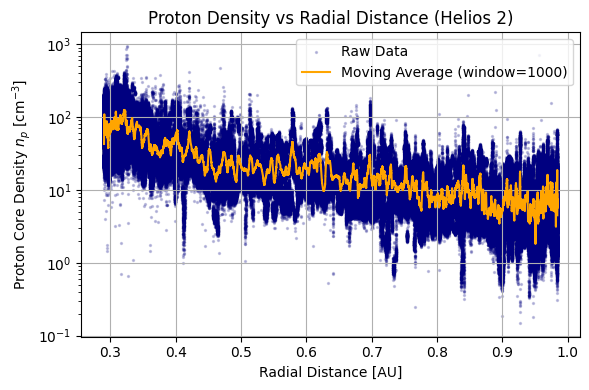

In [25]:
plt.figure(figsize=(6, 4))

# Raw data scatter plot
plt.scatter(df_clean['r_sun'], df_clean['n_p'], s=2, alpha=0.2, color='navy', label='Raw Data')

# Smoothed moving average line
plt.plot(df_clean['r_sun'], df_clean['n_p_smooth'], color='orange', label=f'Moving Average (window={window_size})')

# Plot formatting
plt.xlabel('Radial Distance [AU]')
plt.ylabel('Proton Core Density $n_p$ [cm$^{-3}$]')
plt.title('Proton Density vs Radial Distance (Helios 2)')
plt.yscale('log')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [26]:
def plot_quantities_grid(df, quantities, title, n_cols=3, window_size=None):
    import numpy as np
    import matplotlib.pyplot as plt

    n_rows = int(np.ceil(len(quantities) / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 4.2 * n_rows), sharex=True)
    axs = axs.flatten()

    plotted = 0  # Count how many plots were actually drawn

    for i, (key, label) in enumerate(quantities):
        ax = axs[i]

        # Skip if column doesn't exist or has only NaNs
        if key not in df.columns or df[key].dropna().empty:
            ax.axis('off')
            continue

        # Clean and sort
        data = df[['r_sun', key]].dropna().sort_values('r_sun').copy()
        if data.empty:
            ax.axis('off')
            continue

        # Raw data
        ax.scatter(data['r_sun'], data[key], s=1, alpha=0.4, color='navy', label='Raw')

        # Moving average
        if window_size is not None:
            smoothed = data[key].rolling(window=window_size, center=True).mean()
            data['smooth'] = smoothed
            data.dropna(subset=['smooth'], inplace=True)
            ax.plot(data['r_sun'], data['smooth'], color='orange', lw=1.2, label=f'MA (win={window_size})')

        # Axes and labels
        ax.set_ylabel(label, fontsize=10)
        ax.grid(True)
        if (data[key] > 0).all():
            ax.set_yscale('log')

        if window_size is not None and plotted == 0:
            ax.legend(fontsize=8)

        plotted += 1

    # X-label for bottom row
    for ax in axs[-n_cols:]:
        if ax.has_data():
            ax.set_xlabel('Radial Distance [AU]', fontsize=11)

    # Turn off any remaining unused axes
    for i in range(len(quantities), len(axs)):
        axs[i].axis('off')

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


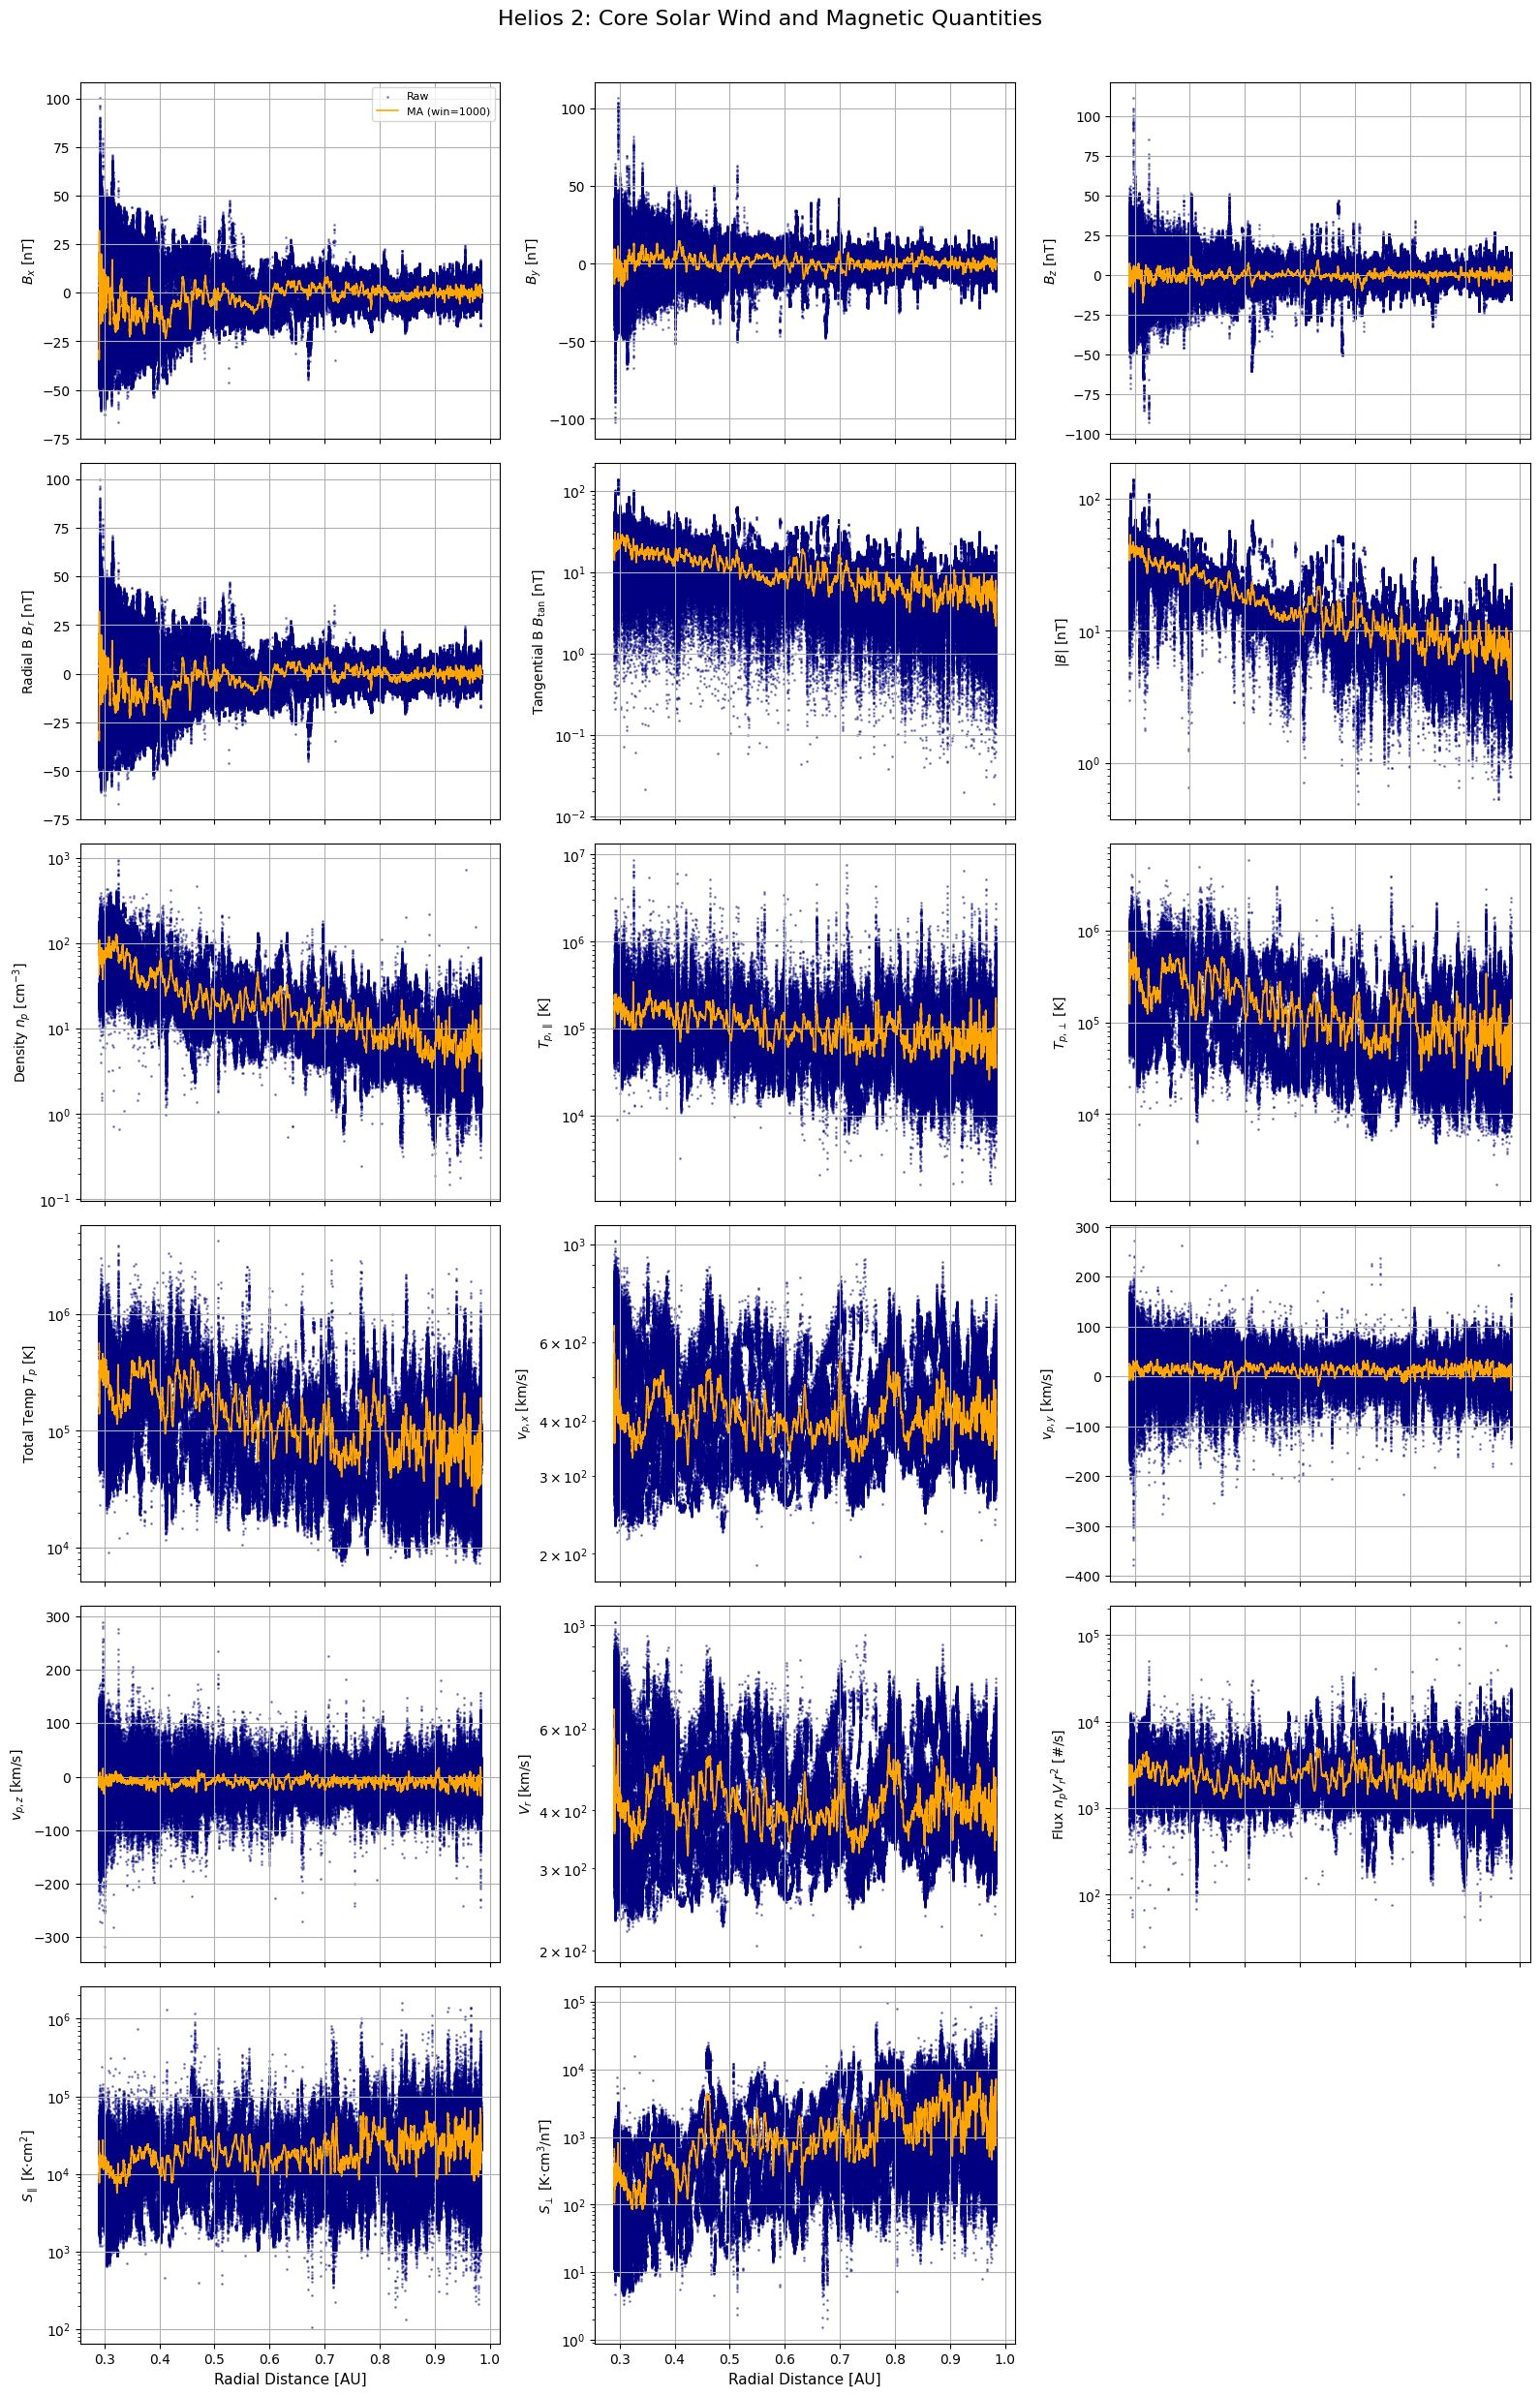

In [27]:
# === Plot Core Quantities ===
plot_quantities_grid(
    df=Helios2,
    quantities=core_quantities,
    title="Helios 2: Core Solar Wind and Magnetic Quantities",
    window_size=1000  # You can change this to 300, 2000, etc.
)

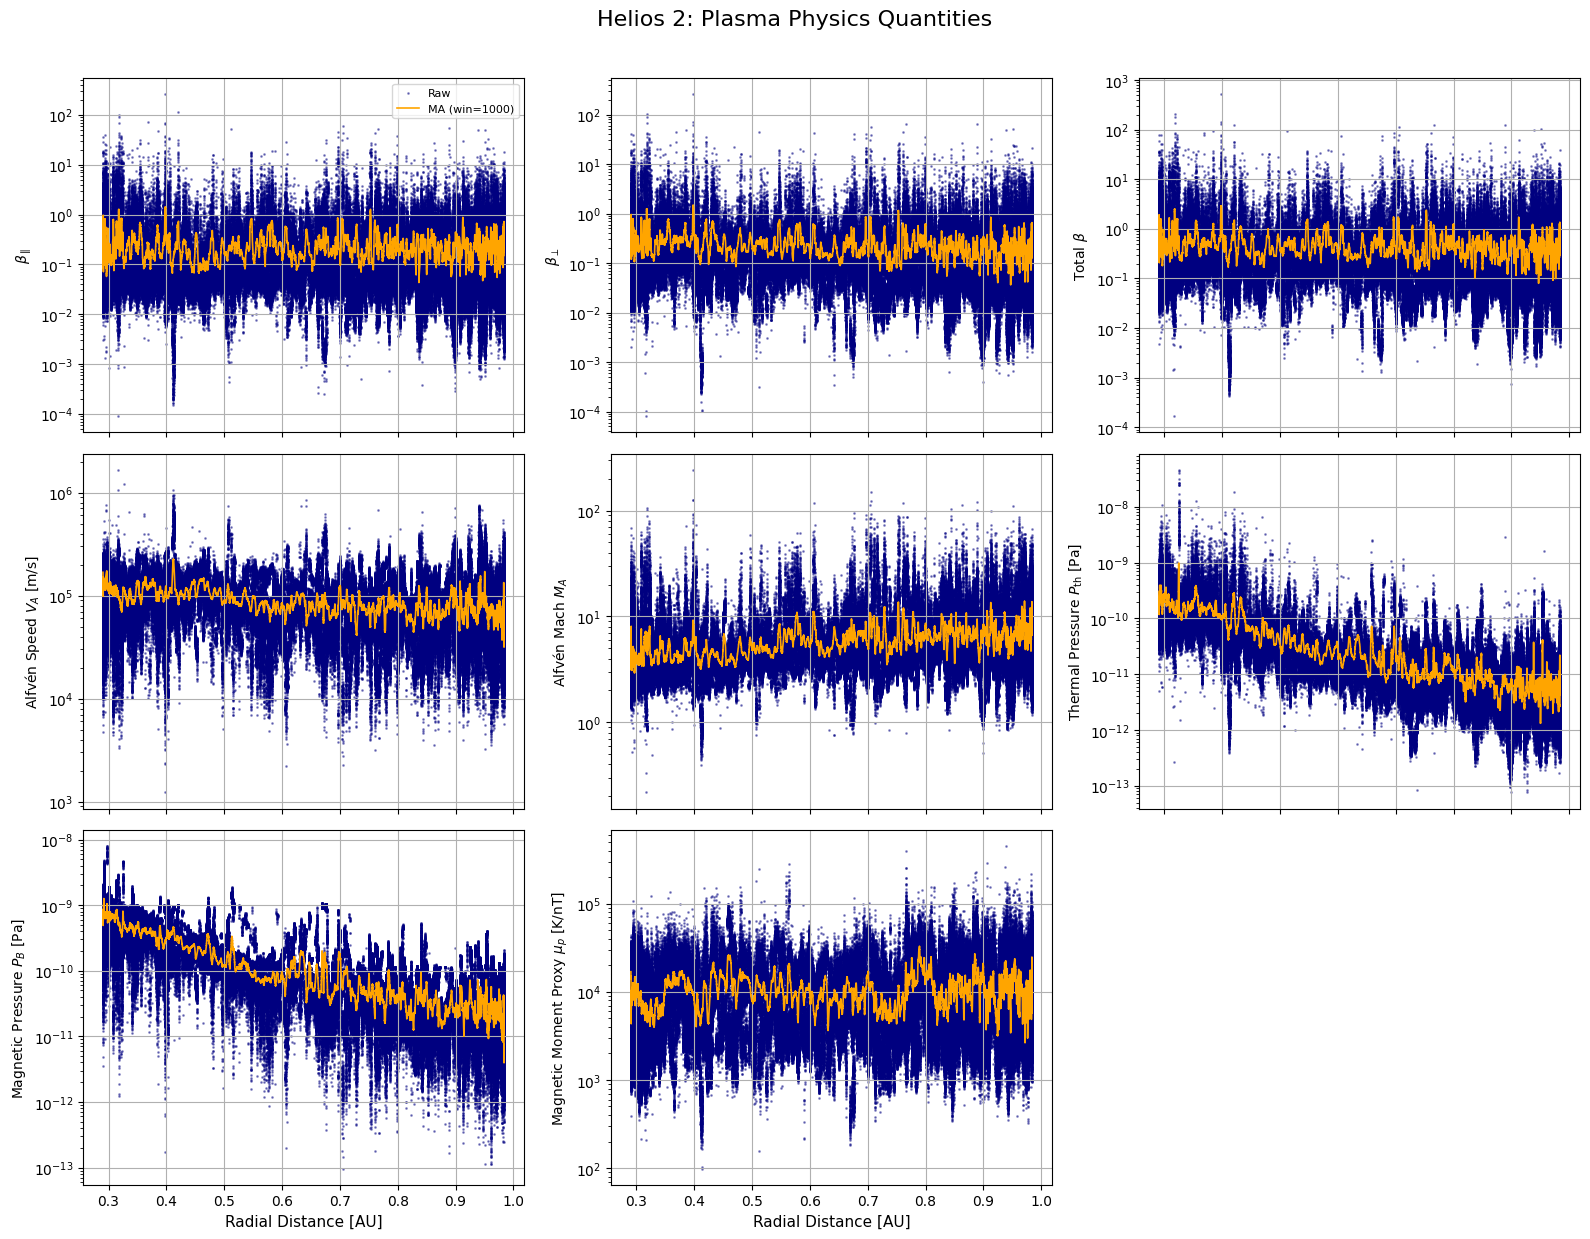

In [28]:
# === Plot Additional Plasma Quantities ===
plot_quantities_grid(
    df=Helios2,
    quantities=plasma_quantities,
    title="Helios 2: Plasma Physics Quantities",
    window_size=1000
)

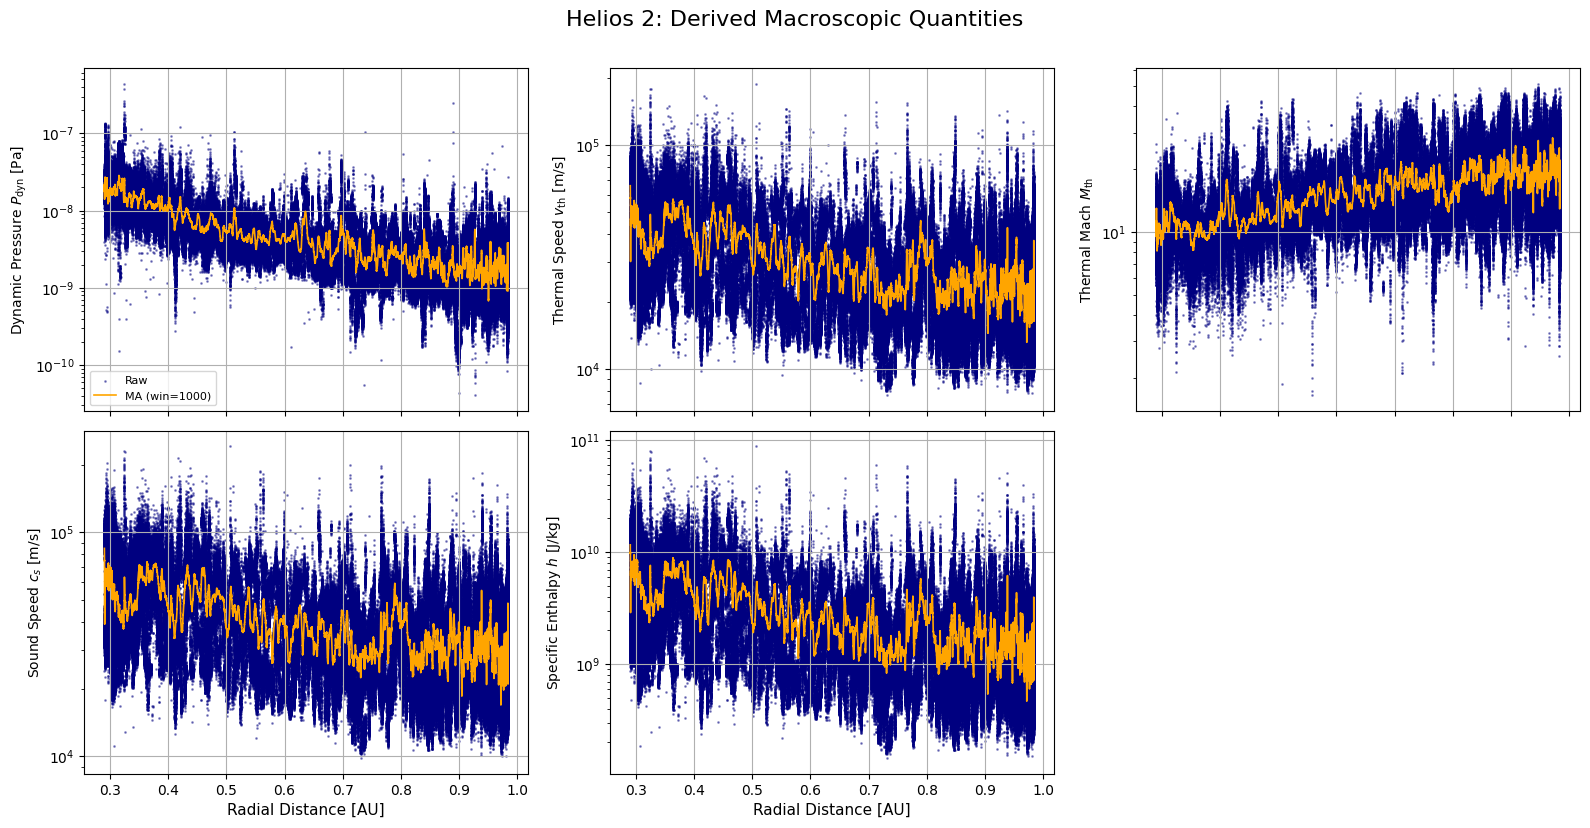

In [29]:
# === Plot Macroscopic Quantities ===
plot_quantities_grid(
    df=Helios2,
    quantities=macro_quantities,
    title="Helios 2: Derived Macroscopic Quantities",
    window_size=1000
)

 ## **Discussion Questions**

1) How does the solar wind parameters change with radial distance?

2) Does temperature decrease like a power law?

3) Is velocity relatively constant?

5) Where does magnetic pressure dominate over thermal pressure?

# **Radial Trends**

## **Introduction**

During the lecture you have derived the radial trends of a spherically expanding solar wind using the MHD model, which are $n \propto R^{-2}$ and $B \propto R^{-2}$. (ADD the OTHER SCALINGS)

Now let's calculate these scalings from the observations.




## **Plotting and Calculation of Radial trends**

You're trying to fit a relationship of the form:

$$
n_p(r) = A \cdot r^{-k}
$$

Where:

- $n_p$: proton number density  
- $r$: radial distance (in AU)  
- $A$: reference value (density at $r = 1$ AU)  
- $k$: power-law exponent (index)


To fit this model, take the natural logarithm of both sides:

$$
\ln n_p = \ln A - k \cdot \ln r
$$

This becomes a **linear equation** in log-log space:

$$
y = mx + b
$$

Where:

- $y = \ln n_p$  
- $x = \ln r$  
- $m = -k$: slope is the negative of the power-law index  
- $b = \ln A$: intercept is the log of the reference value

The Python function `np.polyfit(x, y, deg=1)` fits a polynomial of degree 1 to $ y $ vs. $ x $.

Here:
\begin{align*}
x &= \ln(r) \\
y &= \ln(n_p)
\end{align*}

So the result is:
$$
\ln n_p = a \cdot \ln r + b \quad \Rightarrow \quad n_p = e^{b} \cdot r^{a}
$$

The array 'coeffs' contains:
\begin{align*}
\texttt{coeffs[0]} &= \text{slope } a = -k \\
\texttt{coeffs[1]} &= \text{intercept } b = \ln A
\end{align*}


In [30]:
# Step 0: Select the relevant columns and drop rows with missing values
df_clean = Helios2[['r_sun', 'n_p']].dropna().copy()

# Step 1: Fit a polynomial in log-log space (i.e., log(n_p) vs log(r_sun))
degree = 1  # Linear fit in log-log space → Power law fit: n_p ∝ r^alpha
log_r = np.log(df_clean['r_sun'])
log_n = np.log(df_clean['n_p'])

# Polynomial fit: log(n_p) = alpha * log(r) + log(n_0)
coeffs = np.polyfit(log_r, log_n, deg=degree)

# Extract slope and intercept
alpha_n = coeffs[0]          # Power-law index
n_p0 = np.exp(coeffs[1])     # Reference value at r = 1 AU

# Print the result
print(f"Power-law index (alpha): {alpha_n:.2f}")
print(f"Reference density at 1 AU (n_p0): {n_p0:.2f} cm⁻³")


Power-law index (alpha): -2.07
Reference density at 1 AU (n_p0): 4.99 cm⁻³


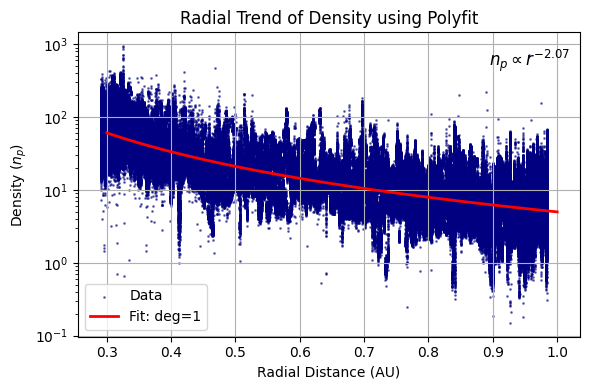

In [31]:
# Step 2: Generate fitted curve
R = np.linspace(0.3, 1.0, 300)
n_fit = n_p0 * (R ** alpha_n)

# Step 3: Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df_clean['r_sun'], df_clean['n_p'], s=1, alpha=0.5, color='navy', label='Data')
ax.plot(R, n_fit, color='red', linewidth=2, label=f'Fit: deg={degree}')

# Auto-positioned annotation (top-right)
fit_label = rf'$n_p \propto r^{{{alpha_n:.2f}}}$'
ax.annotate(fit_label,
            xy=(0.98, 0.95), xycoords='axes fraction',
            fontsize=12, color='black', ha='right', va='top')

# Formatting
ax.set_xlabel('Radial Distance (AU)')
ax.set_ylabel('Density ($n_p$)')
ax.set_title('Radial Trend of Density using Polyfit')
ax.set_yscale('log')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [32]:
def plot_radial_trends_with_fit(df, quantities, title="", degree=1, annotate=True, n_cols=3, log_y=True):
    n_rows = int(np.ceil(len(quantities) / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5.5 * n_cols, 4 * n_rows), sharex=True)
    axs = axs.flatten()

    for i, (key, label) in enumerate(quantities):
        ax = axs[i]

        # Clean and sort data
        df_clean = df[['r_sun', key]].dropna().copy()
        df_clean = df_clean[(df_clean['r_sun'] > 0) & (df_clean[key] > 0)]
        df_clean = df_clean.sort_values('r_sun')

        x = df_clean['r_sun'].values
        y = df_clean[key].values

        # Plot scatter
        ax.scatter(x, y, s=1, alpha=0.5, color='navy', label='Data')

        # Log-log polynomial fit
        if len(x) > degree + 1:
            try:
                logx = np.log(x)
                logy = np.log(y)
                coeffs = np.polyfit(logx, logy, deg=degree)
                alpha = coeffs[0]
                A = np.exp(coeffs[1])
                R = np.linspace(x.min(), x.max(), 300)
                y_fit = A * R**alpha

                ax.plot(R, y_fit, color='red', lw=2, label=fr'$r^{{{alpha:.2f}}}$ fit')

                if annotate:
                    # Use the LaTeX quantity name from label (assumes it's the first part)
                    quantity_name = label.split()[0]
                    annotation = fr'{quantity_name} $\propto r^{{{alpha:.2f}}}$'
                    ax.annotate(
                        annotation,
                        xy=(0.98, 0.95),
                        xycoords='axes fraction',
                        fontsize=12,
                        ha='right', va='top',
                        color='black',
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)
                    )
            except Exception as e:
                print(f"Fit failed for {key}: {e}")

        # Plot formatting
        ax.set_ylabel(label, fontsize=10)
        ax.grid(True)
        if log_y:
            ax.set_yscale('log')

    # X-label for bottom row
    for ax in axs[-n_cols:]:
        ax.set_xlabel('Radial Distance [AU]', fontsize=11)

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    # Title and layout
    fig.suptitle(title, fontsize=15)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


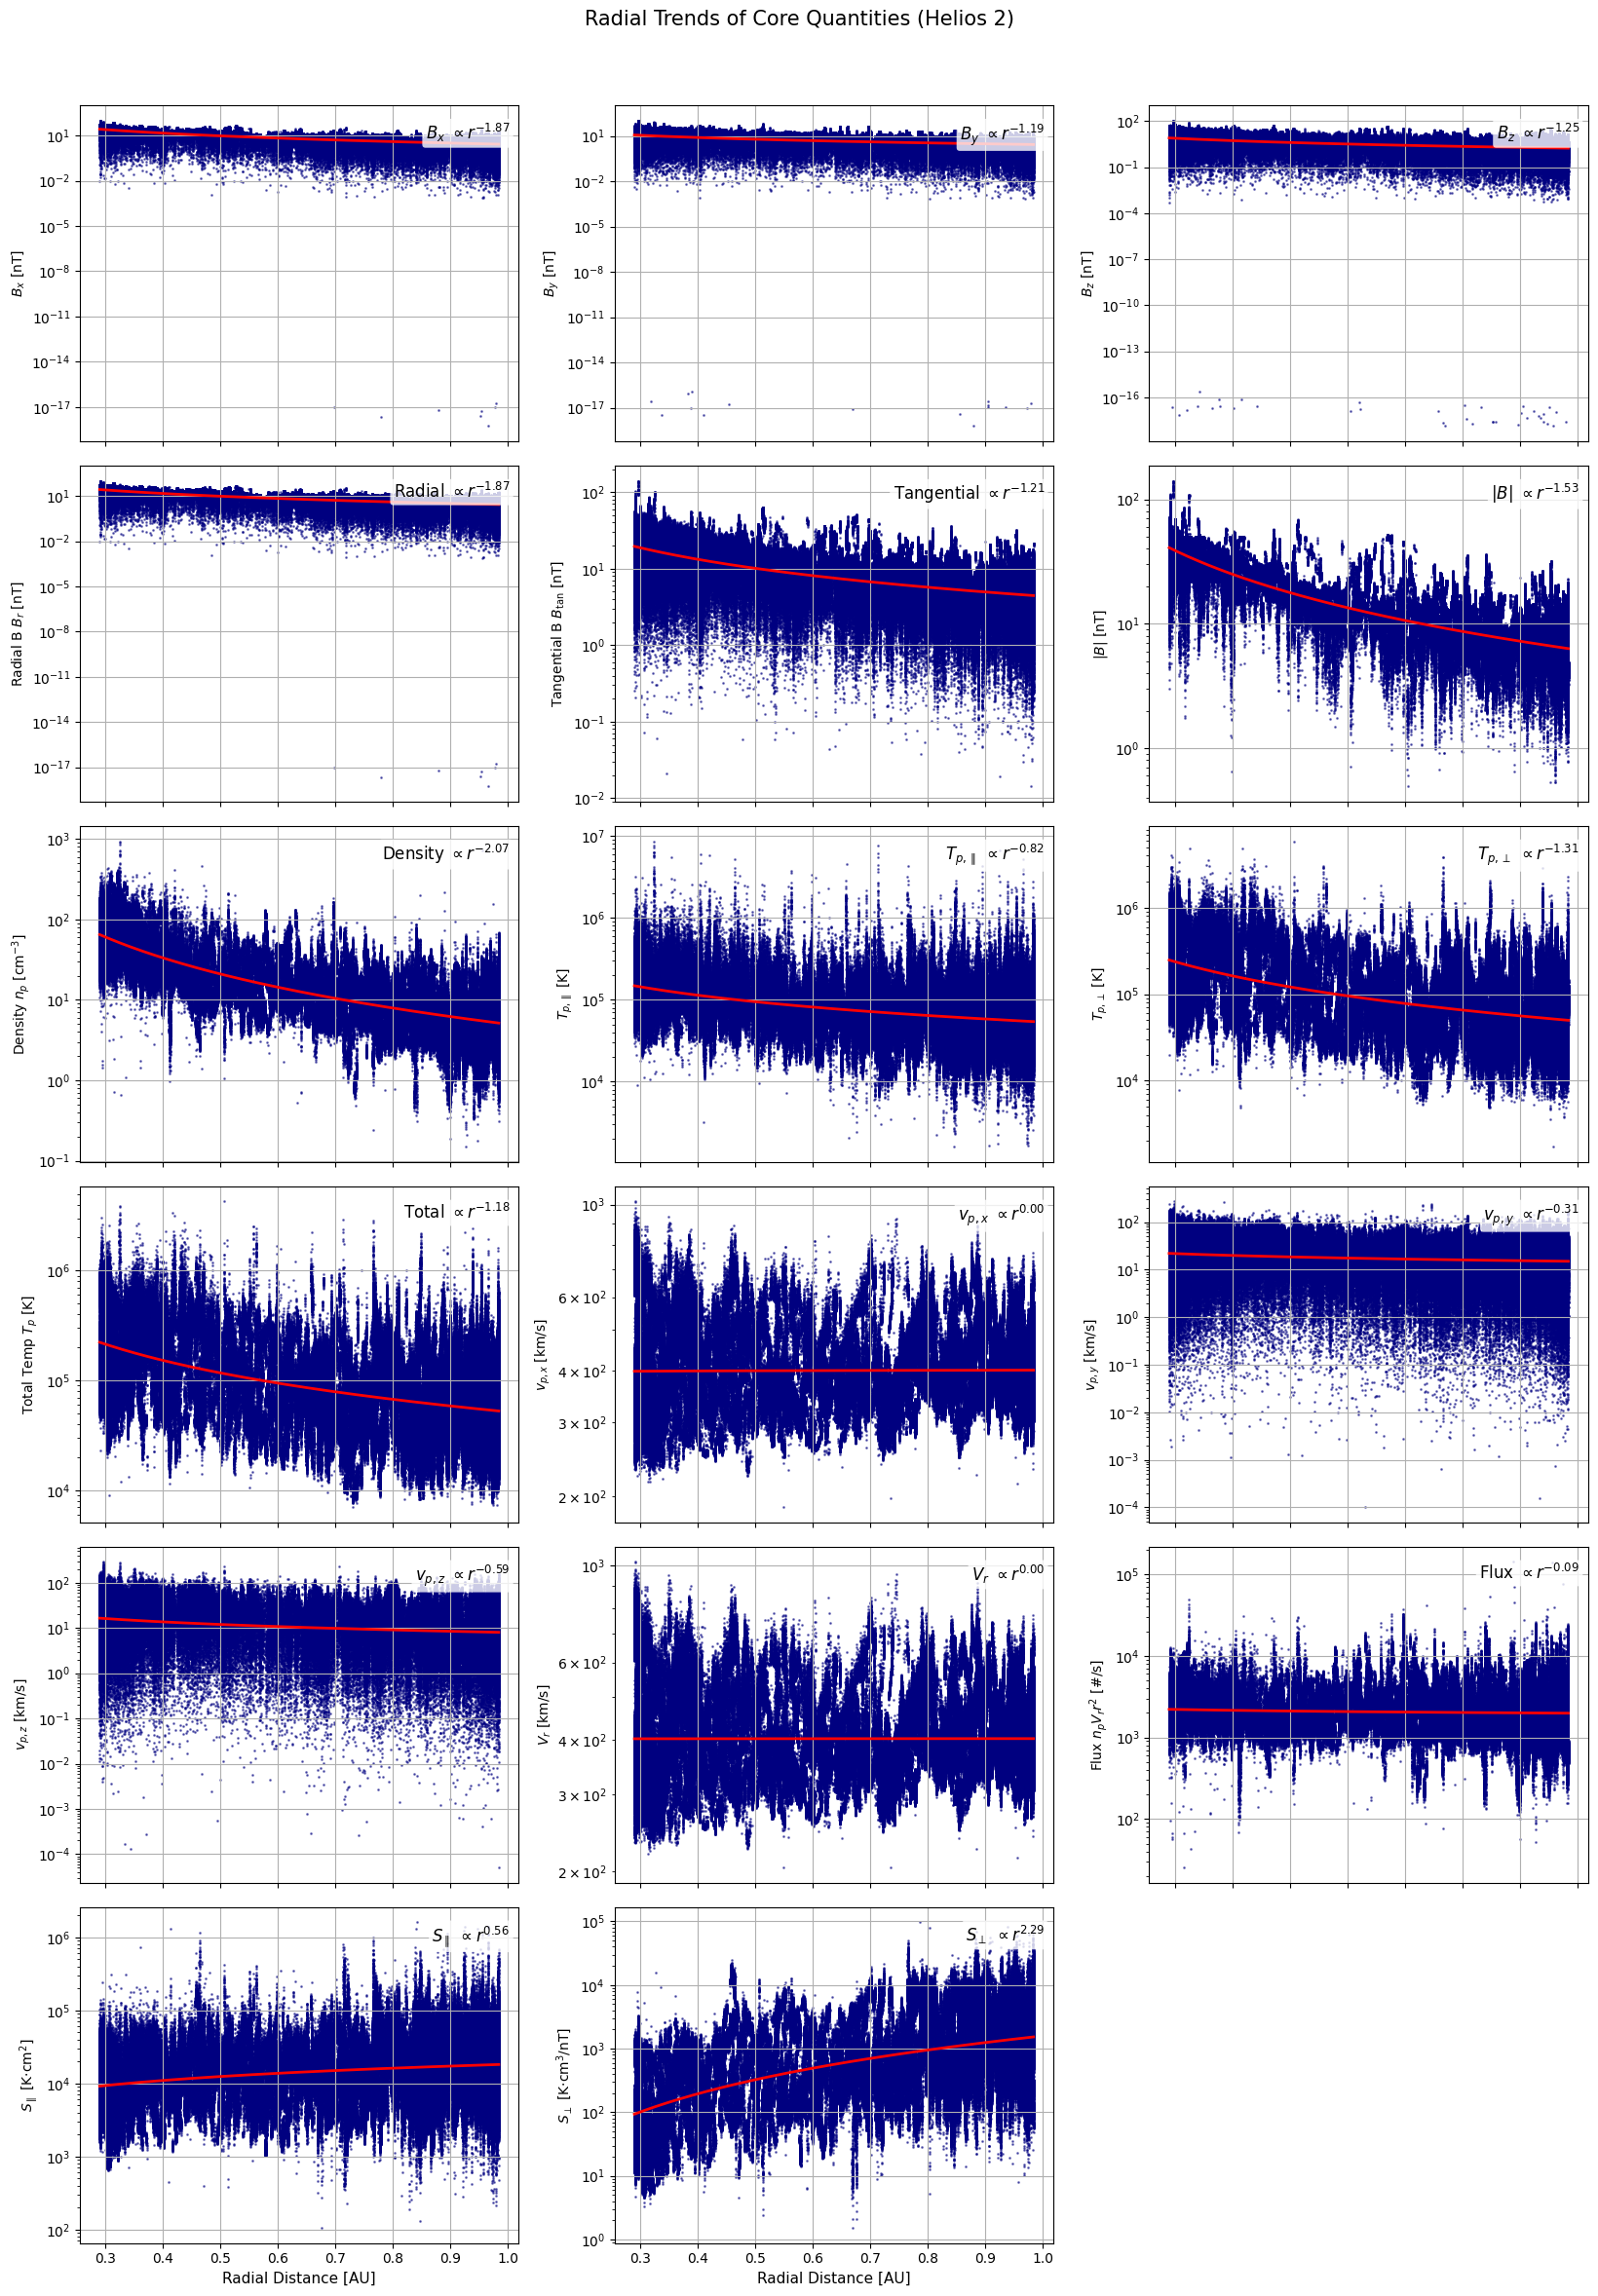

In [33]:
# === Plot Core Quantities ===
plot_radial_trends_with_fit(
    Helios2,
    core_quantities,
    title="Radial Trends of Core Quantities (Helios 2)",
    degree=1,
    log_y=True  # ensures log-scale for y-axis
)

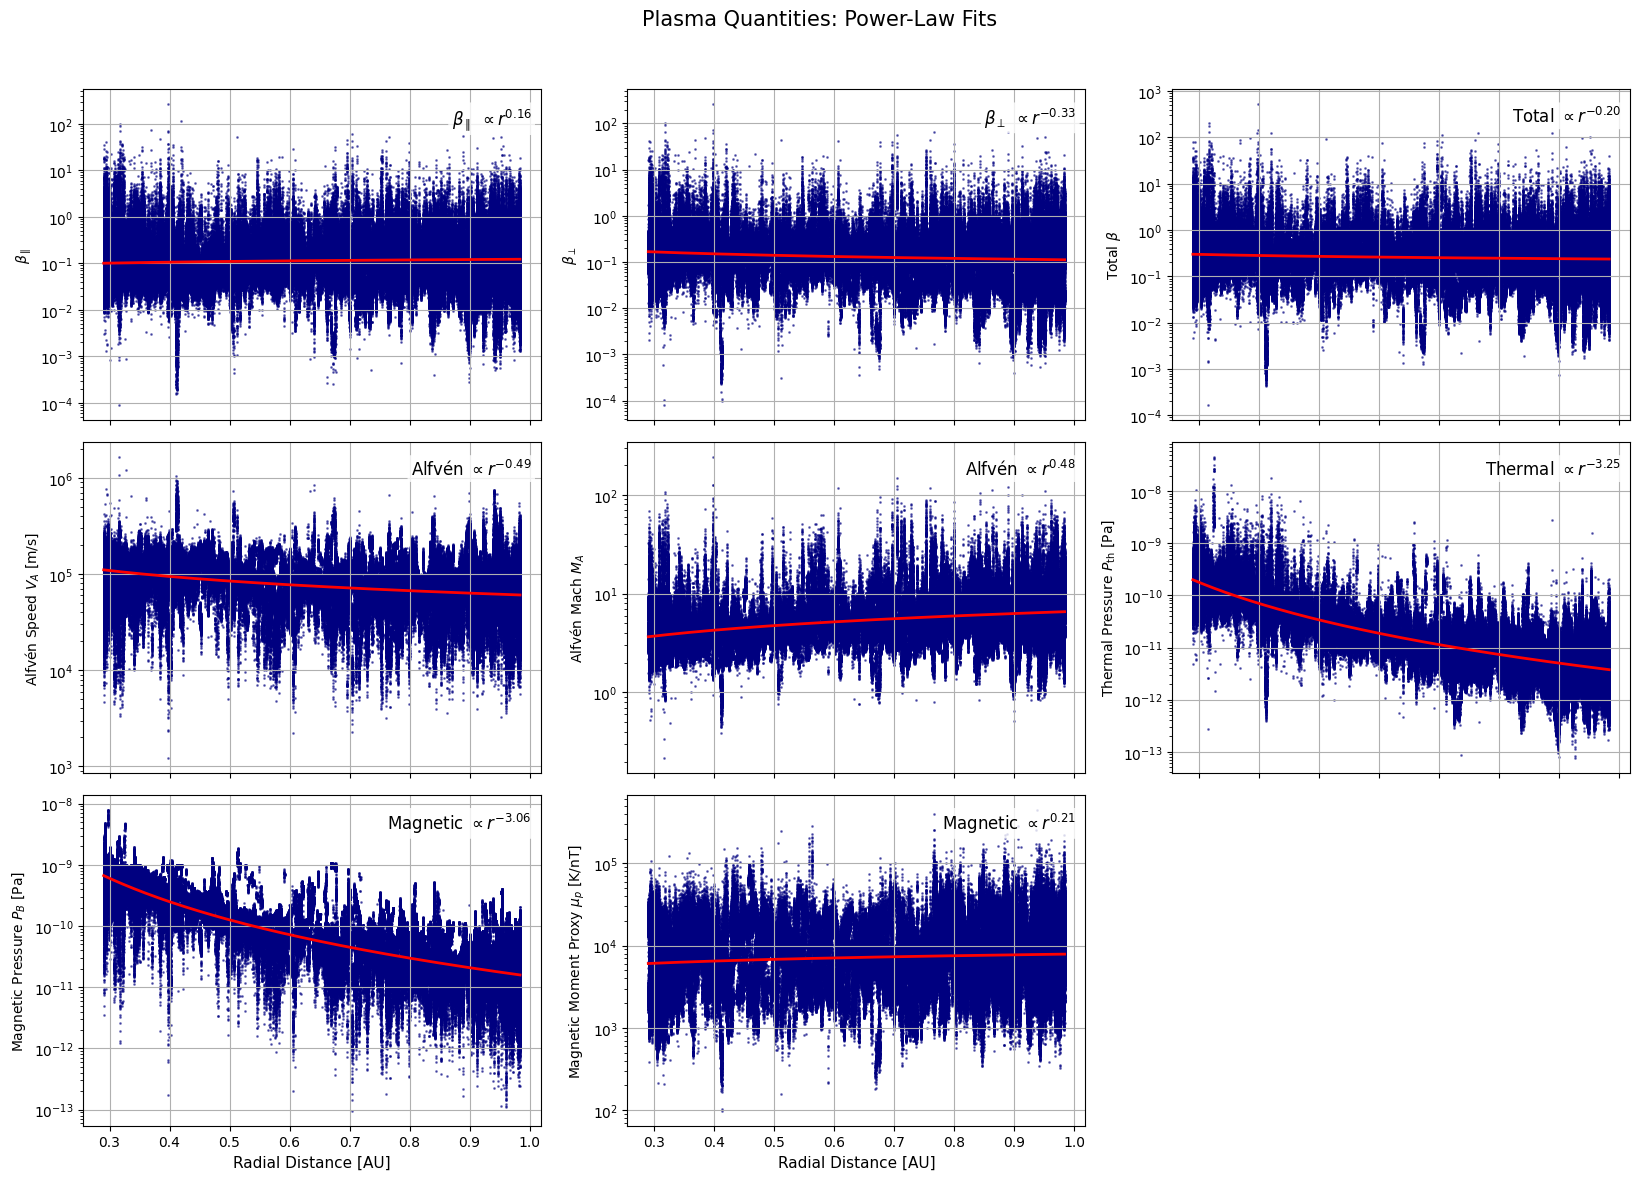

In [34]:
# === Plot Additional Plasma Quantities ===
plot_radial_trends_with_fit(
    Helios2,
    plasma_quantities,
    title='Plasma Quantities: Power-Law Fits',
    degree=1,
    log_y=True
)

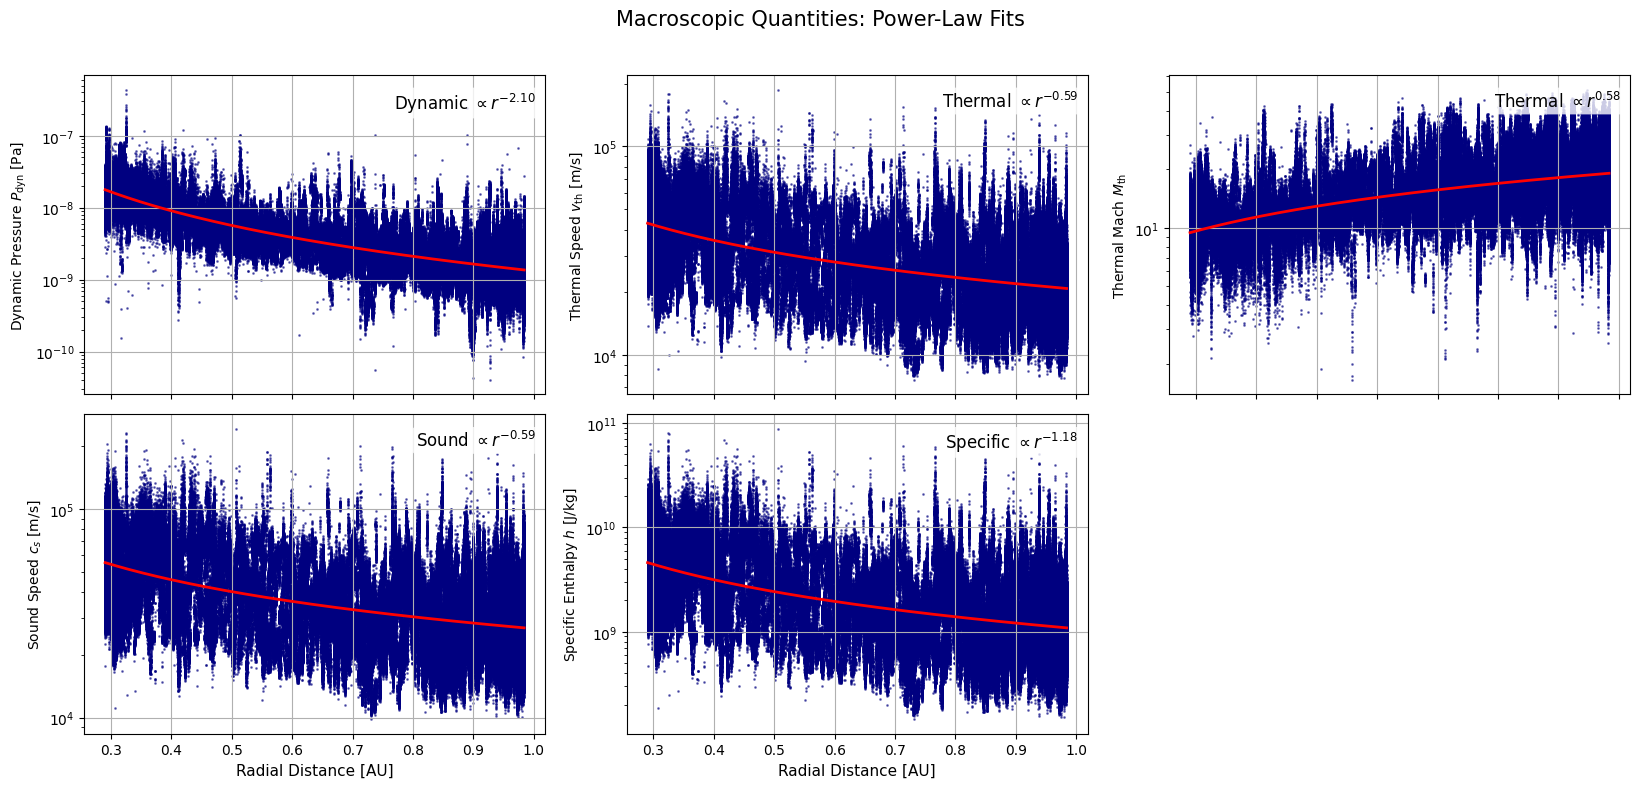

In [35]:
# === Plot Macroscopic Quantities ===
plot_radial_trends_with_fit(
    Helios2,
    macro_quantities,
    title='Macroscopic Quantities: Power-Law Fits',
    degree=1,
    log_y=True
)

In [36]:
def compute_radial_power_laws(df, columns_to_fit, radius_col='r_sun', degree=1, dropna=True):
    """
    Fit power-law exponents to multiple quantities as a function of radial distance.

    Parameters:
    - df: DataFrame containing the data
    - columns_to_fit: list of column names to fit (quantities)
    - radius_col: name of the radial distance column
    - degree: polynomial degree (default 1 for power-law)
    - dropna: whether to drop rows with NaNs

    Returns:
    - Dictionary: {column_name: (alpha, A)} where quantity ∝ r^alpha
    """
    results = {}
    
    for col in columns_to_fit:
        if col not in df.columns:
            results[col] = (np.nan, np.nan)
            continue
        
        data = df[[radius_col, col]].copy()
        if dropna:
            data = data.dropna()
        data = data[(data[radius_col] > 0) & (data[col] > 0)]

        if len(data) <= degree + 1:
            results[col] = (np.nan, np.nan)
            continue

        x = np.log(data[radius_col].values)
        y = np.log(data[col].values)

        try:
            coeffs = np.polyfit(x, y, deg=degree)
            alpha = coeffs[0]
            A = np.exp(coeffs[1])
            results[col] = (alpha, A)
        except Exception:
            results[col] = (np.nan, np.nan)

    return results

# Specify radial distance column
radius_col = 'r_sun'

# Select only float64 and int64 columns, and exclude 'r_sun'
numeric_cols = Helios2.select_dtypes(include=['float64', 'int64']).columns
columns_to_fit = [col for col in numeric_cols if col != radius_col]

# Now apply the compute_radial_power_laws function
result_dict = compute_radial_power_laws(Helios2, columns_to_fit, radius_col=radius_col)

# Optional: Convert to DataFrame for easier display or export
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['alpha', 'A'])
result_df = result_df.dropna().sort_values('alpha')  # Optional sorting

# Display
result_df.head()


alpha             A
P_th  -3.254858  3.565537e-12
P_B   -3.059757  1.509156e-11
P_dyn -2.103059  1.317779e-09
n_p   -2.074957  4.988718e+00
clat  -1.970806  5.376416e-01

## **Parker Spiral**

# Solar Wind Velocity Profile and the Parker Spiral

In this section, we numerically investigate the velocity profile of the solar wind under the assumption of isothermal expansion. The model stems from Parker’s (1958) seminal work, which describes the outflow of plasma from the solar corona as a steady, spherically symmetric, and isothermal flow. This leads to a first-order nonlinear differential equation that governs the radial velocity $ u(r) $ as a function of heliocentric distance $ r $:

$$
\frac{du(r)}{dr} = \left( \frac{4kT}{mr} - \frac{GM}{r^2} \right)^{-1} u(r) \left( u(r)^2 - \frac{2kT}{m} \right)
\tag{1}
$$

To facilitate numerical integration and minimize errors due to scale differences, the equation is rendered dimensionless by introducing normalized variables based on the critical (sonic) point, where $ u = c_s $ and $ r = r_c $. The sound speed $ c_s $ and critical radius $ r_c $ are given by:

$$
c_s^2 = \frac{2kT}{m}, \quad
r_c = \frac{GM}{2c_s^2}
$$

Substituting into the original formulation yields the dimensionless form:

$$
\frac{dv}{dR} = \frac{2\left( \frac{1}{R} - \frac{1}{R^2} \right)}{v - \frac{1}{v}}
\tag{2}
$$

Here, $ v = u / c_s $ and $ R = r / r_c $. The critical point lies at $ v = 1 $, $ R = 1 $, and the physical solution must pass through this point smoothly to remain physically meaningful. The boundary condition is often set at the solar radius, with $ v(R_\odot) = v_0 $, where $ R_\odot = R_{\text{sun}} / r_c $.


## The Parker Spiral and Lagrangian Coordinates

As the solar wind flows outward, it carries the solar magnetic field, which becomes wound into a spiral shape due to the Sun's rotation. This structure is known as the **Parker spiral**. To derive the spiral geometry, we transform the problem into a rotating Lagrangian frame co-moving with the plasma.

The azimuthal angle $ \psi $ describing the spiral is governed by:

$$
\frac{d\psi}{dR} = -\frac{\omega}{v(R)}
\tag{3}
$$

where $ \omega $ is the angular velocity of solar rotation, and $ v(R) $ is the dimensionless solar wind speed from the earlier solution.


## Physical Background

The solar wind is a continuous, supersonic stream of charged particles—primarily protons, electrons, and alpha particles—originating from the hot solar corona. Due to the high coronal temperatures, particles acquire sufficient kinetic energy to overcome solar gravity. The outflow is further influenced by the Sun's magnetic field and rotation, leading to a complex but predictable structure.

Early observational hints of this wind came from Biermann (1951), who inferred a radial solar outflow from the behavior of comet tails. Parker formalized the theory, initially neglecting magnetic effects, and showed that under isothermal and steady-state conditions, the solar corona could not be in hydrostatic equilibrium but must expand outward, forming what is now known as the **Parker solar wind model**.



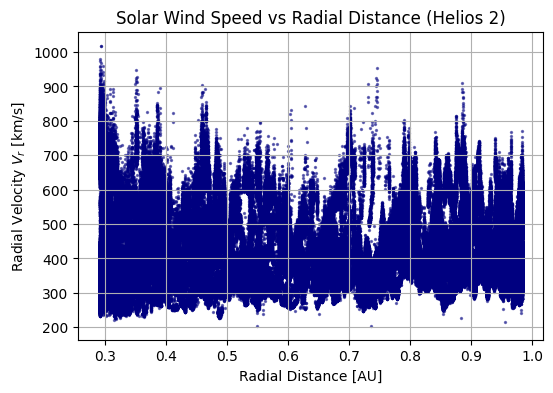

In [37]:
plt.figure(figsize=(6, 4))
plt.scatter(Helios2['r_sun'], Helios2['V_r'], s=2, alpha=0.5, color='navy')
plt.xlabel('Radial Distance [AU]')
plt.ylabel('Radial Velocity $V_r$ [km/s]')
plt.title('Solar Wind Speed vs Radial Distance (Helios 2)')
plt.grid(True)
plt.show()

In [38]:
# --- Constants ---
AU = 1.496e11             # Astronomical Unit in meters
omega_s = 2.865e-6        # Solar rotation rate [rad/s] (~25-day period)

In [39]:
def plot_parker_spiral_subplot(df, color_by='B', ax=None):
    # --- Clean and prepare data ---
    df = df[['r_sun', 'V_r', 'B_r', 'B_tan']].dropna().sort_values('r_sun')
    R_au = df['r_sun'].values
    v_kms = df['V_r'].values
    B_r = df['B_r'].values
    B_tan = df['B_tan'].values

    R_m = R_au * AU
    v = v_kms * 1e3
    B_mag = np.sqrt(B_r**2 + B_tan**2)

    # --- Spiral angle using Euler integration ---
    psi = [0]
    for i in range(len(R_m) - 1):
        dR = R_m[i+1] - R_m[i]
        dpsi = -omega_s * dR / v[i]
        psi.append(psi[-1] + dpsi)
    psi = np.array(psi)
    R_plot = R_au[:len(psi)]

    # --- Generate 4 spiral arms (90° rotated) ---
    arms = [psi + i * np.pi/2 for i in range(4)]

    # --- Arrow sampling ---
    N_skip = 800  # more arrows
    idx = np.arange(0, len(R_plot), N_skip)
    r_arrows = R_plot[idx]
    theta_arrows = psi[idx]

    if color_by == 'V_r':
        color_vals = v_kms[idx]
        cbar_label = 'Solar Wind Speed [km/s]'
    elif color_by == 'B':
        color_vals = B_mag[idx]
        cbar_label = 'Magnetic Field Strength [nT]'
    else:
        raise ValueError("color_by must be 'V_r' or 'B'")

    # --- Arrow vectors ---
    arrow_angle = theta_arrows + np.pi / 2
    arrow_length = 0.08  # Adjusted for visibility
    u = arrow_length * np.cos(arrow_angle)
    v = arrow_length * np.sin(arrow_angle)

    # --- Color map ---
    cmap = plt.cm.plasma
    norm = plt.Normalize(vmin=np.min(color_vals), vmax=np.max(color_vals))

    # --- Plot spiral arms ---
    for arm in arms:
        ax.plot(arm, R_plot, color='black', lw=1.3)

    # --- Plot arrows on each arm with better quiver style ---
    for i in range(4):
        rot = i * np.pi / 2
        ax.quiver(theta_arrows + rot, r_arrows, u, v,
                  color=cmap(norm(color_vals)),
                  scale_units='xy', scale=1,
                  width=0.0045, headwidth=30, headlength=10, headaxislength=10)

    # --- Polar formatting ---
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("E")
    ax.set_rlabel_position(135)
    ax.set_rticks([0.3, 0.5, 0.7, 1.0])
    ax.set_title(cbar_label, fontsize=12)

    return cmap, norm, cbar_label


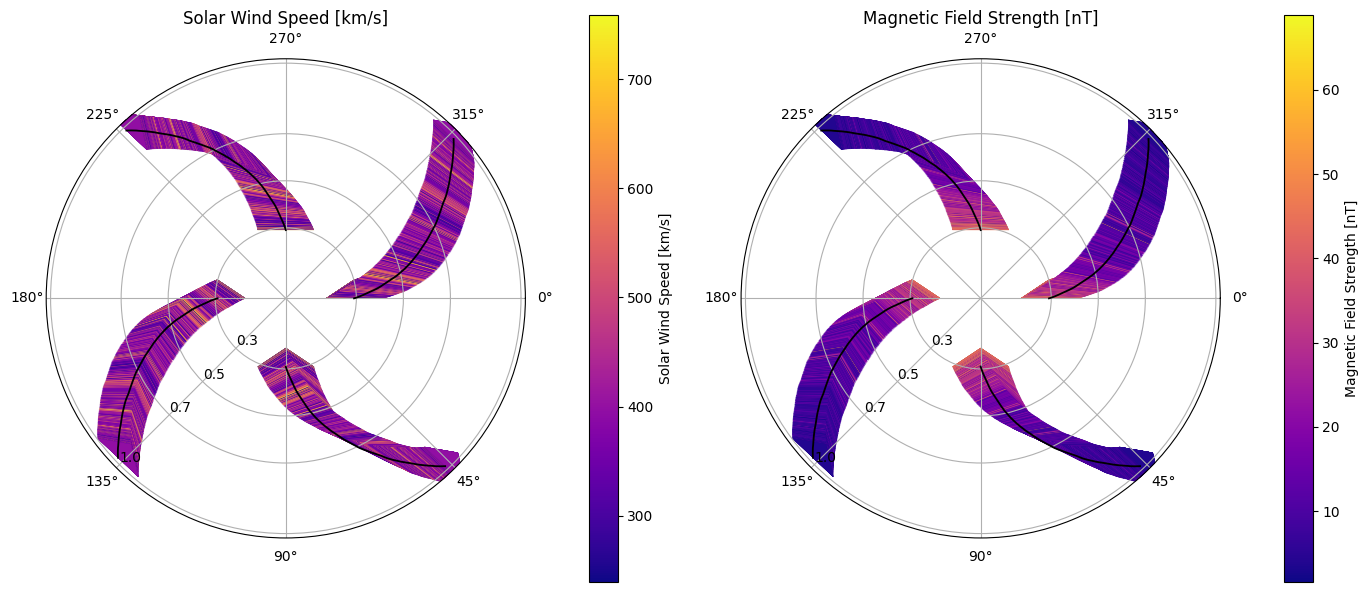

In [40]:
# === Create subplot figure ===
fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': 'polar'})

# Left: V_r spiral
cmap1, norm1, label1 = plot_parker_spiral_subplot(Helios2, color_by='V_r', ax=axs[0])
cbar1 = fig.colorbar(plt.cm.ScalarMappable(norm=norm1, cmap=cmap1), ax=axs[0], pad=0.1)
cbar1.set_label(label1)

# Right: B spiral
cmap2, norm2, label2 = plot_parker_spiral_subplot(Helios2, color_by='B', ax=axs[1])
cbar2 = fig.colorbar(plt.cm.ScalarMappable(norm=norm2, cmap=cmap2), ax=axs[1], pad=0.1)
cbar2.set_label(label2)

plt.tight_layout()
plt.show()


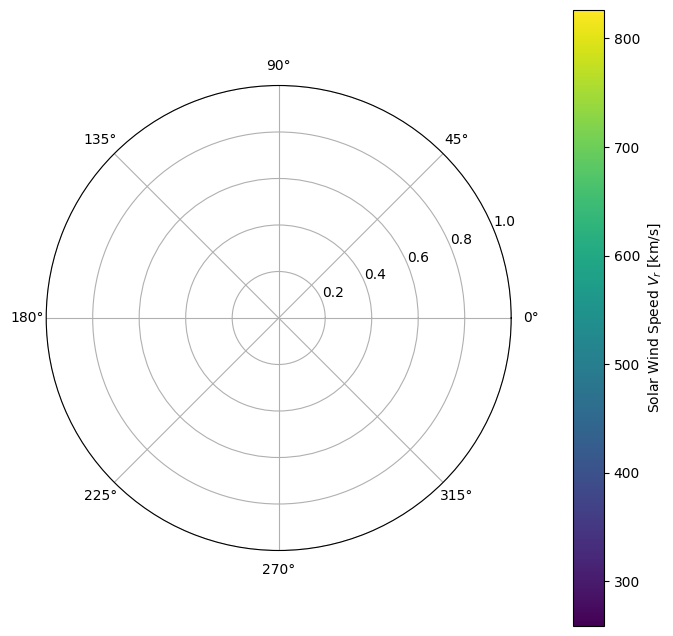

In [41]:
# --- Data Prep ---
df = Helios2[['r_sun', 'V_r', 'B_r', 'B_tan']].dropna().sort_values('r_sun')
R_au = df['r_sun'].values
v_kms = df['V_r'].values
R_m = R_au * AU
v_mps = v_kms * 1e3

# --- Parker spiral angle ψ computation ---
psi = [0]
for i in range(len(R_m) - 1):
    dR = R_m[i+1] - R_m[i]
    dpsi = -omega_s * dR / v_mps[i]
    psi.append(psi[-1] + dpsi)
psi = np.array(psi)
R_plot = R_au[:len(psi)]

# --- Subsample for arrows ---
N_skip = 1000
idx = np.arange(0, len(R_plot), N_skip)
r_arrows = R_plot[idx]
theta_base = psi[idx]
arrow_angle = theta_base + np.pi/2
arrow_length = 0.05
u = arrow_length * np.cos(arrow_angle)
v = arrow_length * np.sin(arrow_angle)

# --- Color by V_r ---
color_vals = v_kms[idx]
cmap = plt.cm.viridis
norm = plt.Normalize(np.min(color_vals), np.max(color_vals))
colors = cmap(norm(color_vals))

# --- Spiral arms ---
arms = [theta_base + i * np.pi/2 for i in range(4)]

# --- Setup plot ---
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label('Solar Wind Speed $V_r$ [km/s]')

In [42]:
def update(frame):
    ax.clear()
    ax.set_theta_direction(1)
    ax.set_theta_zero_location("E")
    ax.set_rlabel_position(135)
    ax.set_rticks([0.3, 0.5, 0.7, 1.0])
    ax.set_title("Parker Spiral Colored by $V_r$", fontsize=14)

    rot = frame * np.pi / 60

    for i in range(4):
        ax.plot(arms[i] + rot, r_arrows, color='black', lw=1.5)
        ax.quiver(arms[i] + rot, r_arrows, u, v,
                  color=colors,
                  angles='xy', scale_units='xy', scale=1,
                  width=0.0045, headwidth=30, headlength=10, headaxislength=10)

In [43]:
# === Animate & Save ===
ani = FuncAnimation(fig, update, frames=120, interval=200)
ani.save("parker_spiral_Vr.gif", writer=PillowWriter(fps=10))
plt.close()

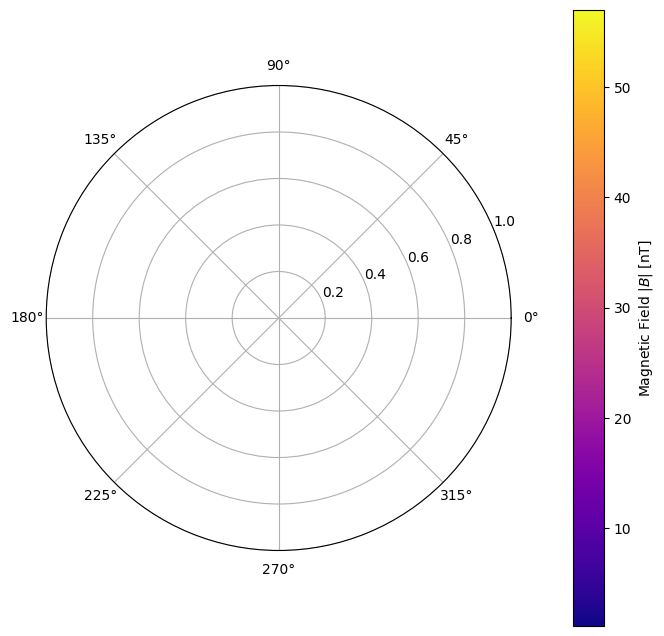

In [44]:
# --- Extend data to include B field ---
B_r = df['B_r'].values
B_tan = df['B_tan'].values
B_mag = np.sqrt(B_r**2 + B_tan**2)
color_vals = B_mag[idx]

# Update color mapping
cmap = plt.cm.plasma
norm = plt.Normalize(np.min(color_vals), np.max(color_vals))
colors = cmap(norm(color_vals))

# New colorbar label
cbar_label = r'Magnetic Field $|B|$ [nT]'

# Plot setup
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label(cbar_label)

In [45]:
# === Animation Function ===
def update_B(frame):
    ax.clear()
    ax.set_theta_direction(1)
    ax.set_theta_zero_location("E")
    ax.set_rlabel_position(135)
    ax.set_rticks([0.3, 0.5, 0.7, 1.0])
    ax.set_title("Parker Spiral Colored by $|B|$", fontsize=14)

    rot = frame * np.pi / 60

    for i in range(4):
        ax.plot(arms[i] + rot, r_arrows, color='black', lw=1.5)
        ax.quiver(arms[i] + rot, r_arrows, u, v,
                  color=colors,
                  angles='xy', scale_units='xy', scale=1,
                  width=0.0045, headwidth=30, headlength=10, headaxislength=10)

In [46]:
# === Animate & Save ===
ani_B = FuncAnimation(fig, update_B, frames=120, interval=200)
ani_B.save("parker_spiral_B.gif", writer=PillowWriter(fps=10))
plt.close()

## **Discussion**

### Radial Trends: Theory vs Observations

| Plasma Parameter                                     | Theory ($\propto R^{\alpha}$)                | Observations (Fitted)      |
|------------------------------------------------------|-----------------------------------------------|-----------------------------|
| Proton Density ($n_p$)                               | $\propto R^{-2.02 \pm 0.05}$                  | $\propto R^{-2.07}$         |
| Radial Flux ($n_p V_r$)                              | $\propto R^{-1.99 \pm 0.05}$                  | $\propto R^{-0.09}$         |
| Magnetic Field Magnitude ($B$)                       | $\propto R^{-1.63 \pm 0.03}$                  | $\propto R^{-1.53}$         |
| Radial Magnetic Field ($|B_r|$)                      | $\propto R^{-1.84 \pm 0.05}$                  | $\propto R^{-1.87}$         |
| Tangential Magnetic Field ($|B_t|$)                  | $\propto R^{-1.29 \pm 0.06}$                  | $\propto R^{-1.21}$         |
| Total Proton Temperature ($T_p$)                     | $\propto R^{-0.90 \pm 0.08}$                  | $\propto R^{-1.18}$         |
| Parallel Temperature ($T_\parallel$)                 | $\propto R^{-0.48 \pm 0.09}$                  | $\propto R^{-0.82}$         |
| Perpendicular Temperature ($T_\perp$)                | $\propto R^{-0.99 \pm 0.08}$                  | $\propto R^{-1.31}$         |
| Kinetic Pressure ($P_k$ or $P_{\rm th}$)             | $\propto R^{-2.89 \pm 0.09}$                  | $\propto R^{-3.25}$         |
| Magnetic Pressure ($P_B$)                            | $\propto R^{-3.23 \pm 0.07}$                  | $\propto R^{-3.06}$         |
| Plasma Beta ($\beta$)                                | $\propto R^{0.40 \pm 0.08}$                   | $\propto R^{-0.20}$         |
| Parallel Plasma Beta ($\beta_\parallel$)             | $\propto R^{0.9 \pm 0.1}$                     | $\propto R^{0.16}$          |
| Perpendicular Plasma Beta ($\beta_\perp$)            |                                               | $\propto R^{-0.33}$         |
| Alfvén Speed ($V_A$)                                 | $\propto R^{-0.5}$ (approx.)                  | $\propto R^{-0.49}$         |
| Alfvén Mach Number ($M_A$)                           |                                               | $\propto R^{0.48}$          |
| Dynamic Pressure ($P_{\rm dyn}$)                     |                                               | $\propto R^{-2.10}$         |
| Sound Speed ($c_s$)                                  |                                               | $\propto R^{-0.59}$         |
| Thermal Speed ($v_{\rm th}$)                         | $\propto R^{-0.5}$ (if $T \propto R^{-1}$)    | $\propto R^{-0.59}$         |
| Thermal Mach Number ($M_{\rm th}$)                   |                                               | $\propto R^{0.58}$          |
| Specific Enthalpy ($h$)                              |                                               | $\propto R^{-1.18}$         |
| Magnetic Moment Proxy ($\mu_p$)                      |                                               | $\propto R^{0.21}$          |
| Parallel Entropy ($S_\parallel$)                     |                                               | $\propto R^{0.56}$          |
| Perpendicular Entropy ($S_\perp$)                    |                                               | $\propto R^{2.29}$          |


---
# Refrences:

[1] D. Perrone, D Stansby, T. S. Horbury, and L Matteini, “Radial evolution of the solar wind in pure high-speed streams: HELIOS revised observations,” Monthly Notices of the Royal Astronomical Society, vol. 483, no. 3, pp. 3730–3737, Dec. 2018, doi: https://doi.org/10.1093/mnras/sty3348.

[2] D. Stansby, D. Perrone, L. Matteini, T. S. Horbury, and C. S. Salem, “Alpha particle thermodynamics in the inner heliosphere fast solar wind,” Astronomy and Astrophysics, vol. 623, pp. L2–L2, Feb. 2019, doi: https://doi.org/10.1051/0004-6361/201834900.

[3] D. Stansby, C. Salem, L. Matteini, and T. Horbury, “A New Inner Heliosphere Proton Parameter Dataset from the Helios Mission,” Solar Physics, vol. 293, no. 11, Nov. 2018, doi: https://doi.org/10.1007/s11207-018-1377-3.

[4] Q. Chang et al., “Multiple-point Modeling the Parker Spiral Configuration of the Solar Wind Magnetic Field at the Solar Maximum of Solar Cycle 24,” Astrophysical journal/The Astrophysical journal, vol. 884, no. 2, pp. 102–102, Oct. 2019, doi: https://doi.org/10.3847/1538-4357/ab412a.

[5] E. N. Parker, “Dynamics of the Interplanetary Gas and Magnetic Fields.,” The Astrophysical Journal, vol. 128, p. 664, Nov. 1958, doi: https://doi.org/10.1086/146579.

[6] E. Villegas-Pulgarin, “The Parker Spiral with Python,” Cosmoscalibur, 2024. https://www.cosmoscalibur.com/en/blog/2024/espiral-de-parker-con-python/#numerical-solution (accessed Jul. 13, 2025).